In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.formula.api import ols
from datetime import datetime, timedelta
from dateutil.parser import parse
import os

In [2]:
# Base path untuk dataset
base_path = "/kaggle/input/brazilian-ecommerce/"

# Daftar nama file dataset
datasets = [
    'olist_customers_dataset.csv',
    'olist_geolocation_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'product_category_name_translation.csv'
]

# Fungsi untuk membaca CSV dan menampilkan head()
def read_and_show_head(file_name):
    full_path = os.path.join(base_path, file_name)
    df = pd.read_csv(full_path)
    print(f"\nHead of {file_name}:")
    print(df.head())
    return df

# Fungsi untuk melakukan describe() dan menyimpan hasilnya
def describe_dataset(df, file_name):
    description = df.describe()
    print(f"\nDescription of {file_name}:")
    print(description)
    # Jika Anda ingin menyimpan deskripsi ke file, uncomment baris berikut
    # description.to_csv(f"{file_name}_description.csv")

# Loop untuk setiap dataset
for dataset in datasets:
    try:
        df = read_and_show_head(dataset)
        describe_dataset(df, dataset)
    except Exception as e:
        print(f"Error processing {dataset}: {str(e)}")


Head of olist_customers_dataset.csv:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  

Description of olist_customers_dataset.csv:
       customer_zip_code_prefix
count              99441.000000
mean  

## Checking Missing Value Dan Handling Missing Value

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest

# Base path untuk dataset
base_path = "/kaggle/input/brazilian-ecommerce/"

# Daftar nama file dataset
datasets = [
    'olist_customers_dataset.csv',
    'olist_geolocation_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'product_category_name_translation.csv'
]

def read_csv(file_name):
    full_path = os.path.join(base_path, file_name)
    return pd.read_csv(full_path)

def show_head(df, file_name):
    print(f"\nHead of {file_name}:")
    print(df.head())

def describe_dataset(df, file_name):
    description = df.describe()
    print(f"\nDescription of {file_name}:")
    print(description)

def check_missing_values(df, file_name):
    missing = df.isnull().sum()
    missing_percent = 100 * df.isnull().sum() / len(df)
    missing_table = pd.concat([missing, missing_percent], axis=1, keys=['Missing Values', '% of Total Values'])
    missing_table = missing_table[missing_table['Missing Values'] > 0].sort_values('% of Total Values', ascending=False)
    print(f"\nMissing Values in {file_name}:")
    print(missing_table)

def check_duplicates(df, file_name):
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate Rows in {file_name}: {duplicates}")

def handle_missing_reviews(df):
    df['review_comment_title'] = df['review_comment_title'].fillna('No Title')
    df['review_comment_message'] = df['review_comment_message'].fillna('No Comment')
    return df

def handle_missing_orders(df):
    date_columns = ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
        median_date = df[col].median()
        df[col] = df[col].fillna(median_date)
    return df

def handle_missing_products(df):
    df['product_category_name'] = df['product_category_name'].fillna(df['product_category_name'].mode()[0])
    
    num_cols = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 
                'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
    imputer = IterativeImputer(random_state=0)
    df[num_cols] = pd.DataFrame(imputer.fit_transform(df[num_cols]), columns=num_cols)
    return df

def handle_outliers(df, columns):
    iso_forest = IsolationForest(contamination=0.1, random_state=0)
    outliers = iso_forest.fit_predict(df[columns])
    df_clean = df[outliers != -1]
    return df_clean

# Dictionary untuk menyimpan DataFrame
dataframes = {}

# Main analysis and processing loop
for dataset in datasets:
    try:
        print(f"\n{'='*50}\nAnalyzing and Processing {dataset}\n{'='*50}")
        df = read_csv(dataset)
        
        print("Before Processing:")
        show_head(df, dataset)
        describe_dataset(df, dataset)
        check_missing_values(df, dataset)
        check_duplicates(df, dataset)
        
        # Process the dataset
        if dataset == 'olist_order_reviews_dataset.csv':
            df = handle_missing_reviews(df)
        elif dataset == 'olist_orders_dataset.csv':
            df = handle_missing_orders(df)
        elif dataset == 'olist_products_dataset.csv':
            df = handle_missing_products(df)
            num_cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
            df = handle_outliers(df, num_cols)
        
        print("\nAfter Processing:")
        show_head(df, dataset)
        describe_dataset(df, dataset)
        check_missing_values(df, dataset)
        check_duplicates(df, dataset)
        
        # Simpan DataFrame yang telah diproses
        df_name = dataset.replace('.csv', '').replace('-', '_')
        dataframes[df_name] = df
        globals()[df_name] = df
        
    except Exception as e:
        print(f"Error processing {dataset}: {str(e)}")

print("\nAll datasets have been analyzed and processed. The following DataFrames are now available:")
for df_name in dataframes.keys():
    print(f"- {df_name}")


Analyzing and Processing olist_customers_dataset.csv
Before Processing:

Head of olist_customers_dataset.csv:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  

Description of olist_customers_dataset.cs

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



After Processing:

Head of olist_products_dataset.csv:
                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0          

## Check Columns diatas untuk Elastisitas data

In [4]:
import pandas as pd
import os

# Base path untuk dataset
base_path = "/kaggle/input/brazilian-ecommerce/"

# Daftar nama file dataset
datasets = [
    'olist_customers_dataset.csv',
    'olist_geolocation_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'product_category_name_translation.csv'
]

def check_columns(file_name):
    full_path = os.path.join(base_path, file_name)
    # Hanya membaca kolom-kolom tanpa memuat seluruh data
    columns = pd.read_csv(full_path, nrows=0).columns
    print(f"\nColumns in {file_name}:")
    for col in columns:
        print(f"- {col}")

# Loop untuk memeriksa kolom-kolom setiap dataset
for dataset in datasets:
    try:
        check_columns(dataset)
    except Exception as e:
        print(f"Error checking columns for {dataset}: {str(e)}")

print("\nColumn check completed for all datasets.")


Columns in olist_customers_dataset.csv:
- customer_id
- customer_unique_id
- customer_zip_code_prefix
- customer_city
- customer_state

Columns in olist_geolocation_dataset.csv:
- geolocation_zip_code_prefix
- geolocation_lat
- geolocation_lng
- geolocation_city
- geolocation_state

Columns in olist_order_items_dataset.csv:
- order_id
- order_item_id
- product_id
- seller_id
- shipping_limit_date
- price
- freight_value

Columns in olist_order_payments_dataset.csv:
- order_id
- payment_sequential
- payment_type
- payment_installments
- payment_value

Columns in olist_order_reviews_dataset.csv:
- review_id
- order_id
- review_score
- review_comment_title
- review_comment_message
- review_creation_date
- review_answer_timestamp

Columns in olist_orders_dataset.csv:
- order_id
- customer_id
- order_status
- order_purchase_timestamp
- order_approved_at
- order_delivered_carrier_date
- order_delivered_customer_date
- order_estimated_delivery_date

Columns in olist_products_dataset.csv:
- p

Overall Price Elasticity: -0.16


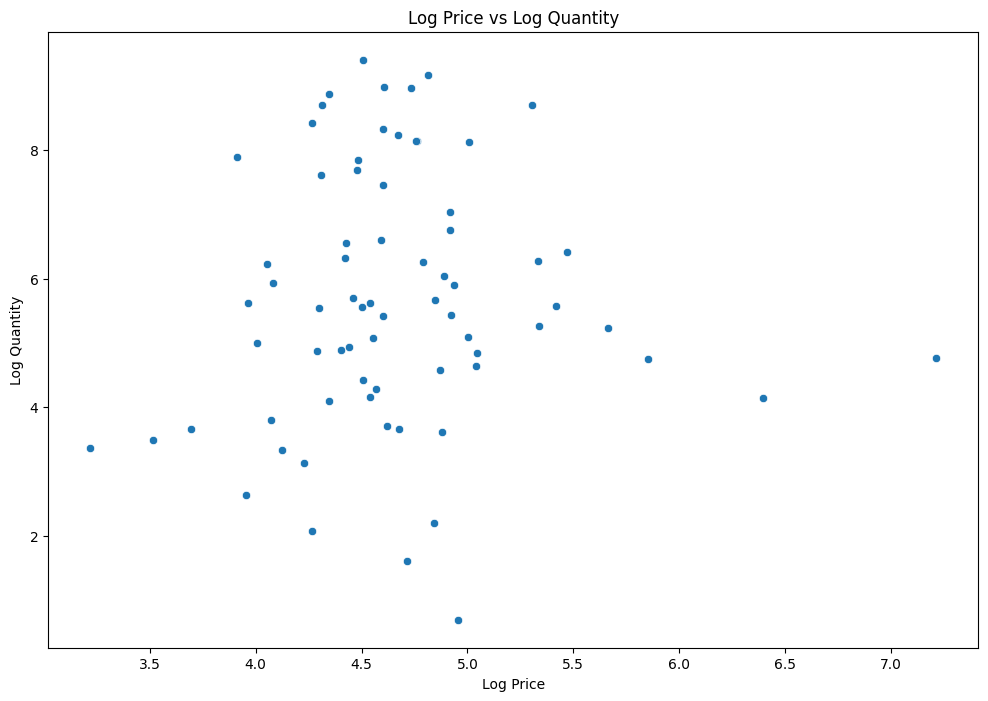

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10917: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10931: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10934: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)



Top 5 Most Elastic Categories:
                             category  quantity   avg_price  log_quantity  \
46                     home_comfort_2        29   25.009655      3.367296   
41  furniture_mattress_and_upholstery         9  126.733333      2.197225   
23                diapers_and_hygiene        39   40.194615      3.663562   
32                      fashion_sport        28   61.882500      3.332205   
29          fashion_childrens_clothes         8   71.231250      2.079442   

    log_price  elasticity  
46   3.219262    1.210319  
41   4.842085    0.723589  
23   3.693733    0.716037  
32   4.125237    0.616494  
29   4.265932    0.601227  

Top 5 Least Elastic Categories:
                                 category  quantity   avg_price  log_quantity  \
8                  books_general_interest       552   83.255399      6.313548   
3                   arts_and_craftmanship        23   68.522174      3.135494   
52                             la_cuisine         5  111.3980

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


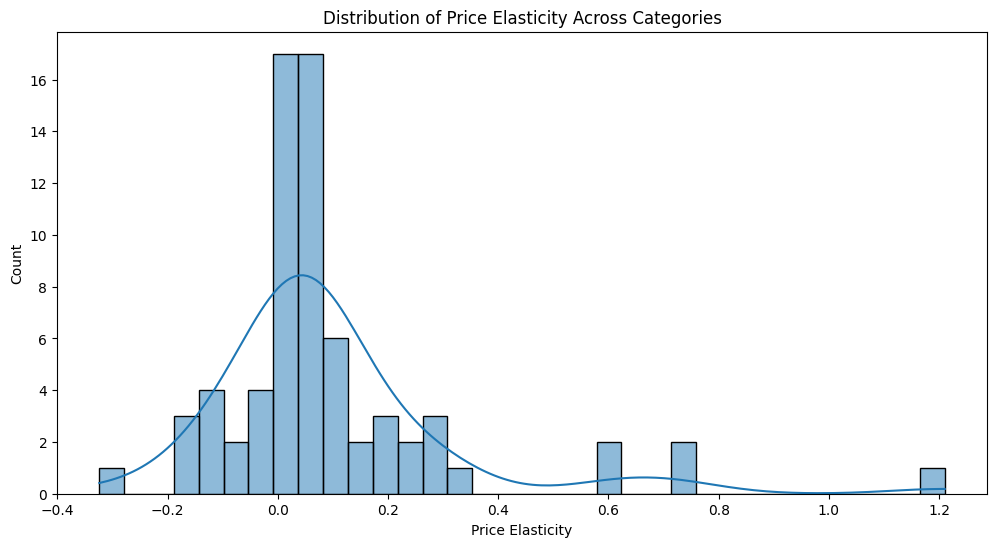

/tmp/ipykernel_78/3858703677.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_elasticities = monthly_sales.groupby('month').apply(monthly_elasticity).reset_index()


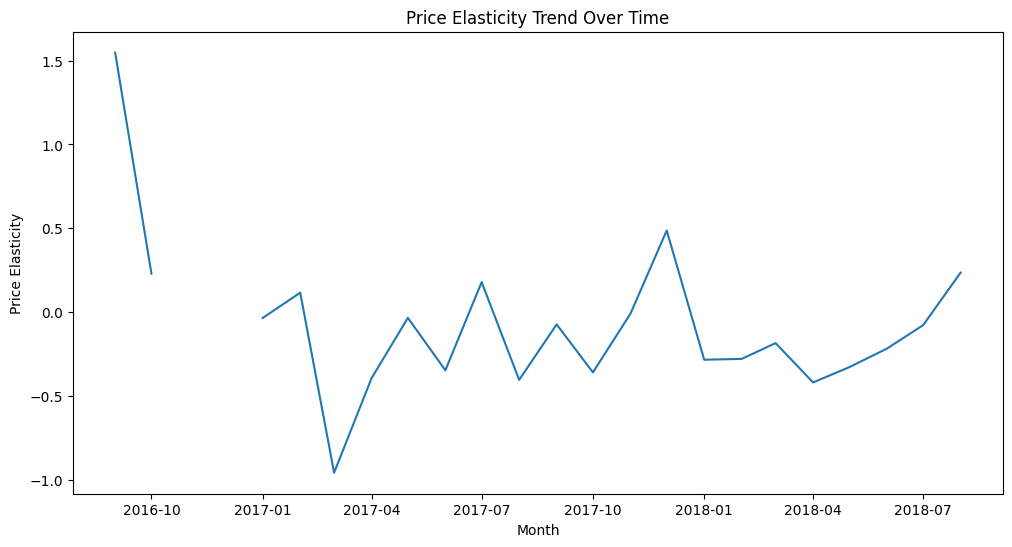

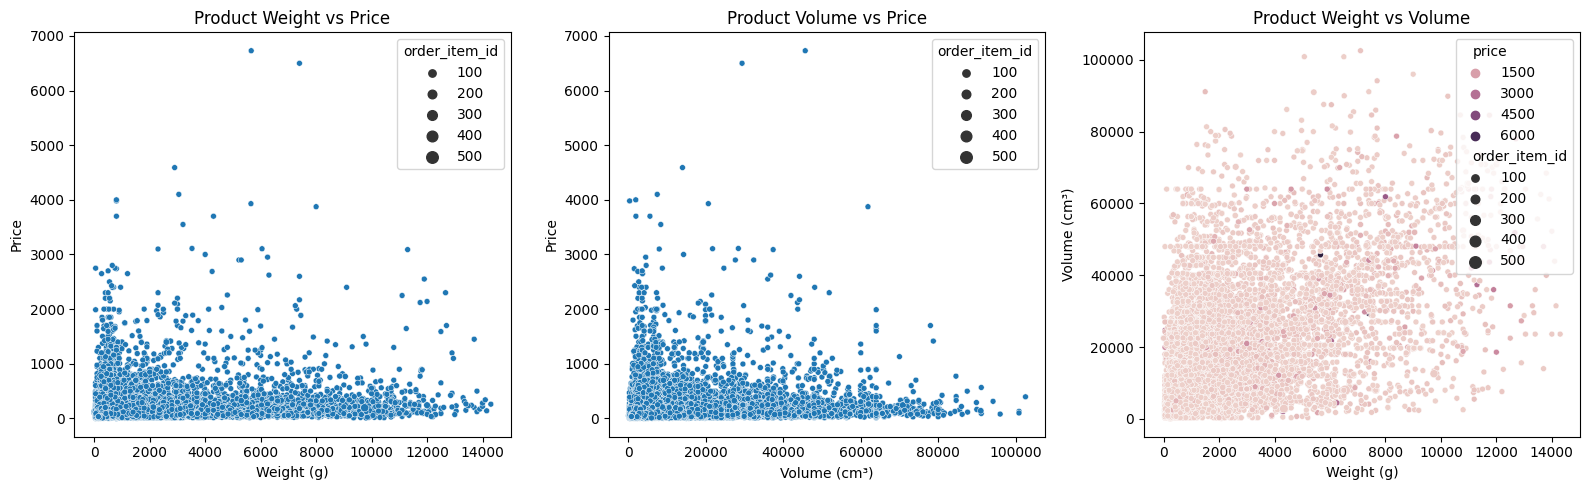

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Pastikan semua DataFrame yang diperlukan tersedia
required_dataframes = [
    'olist_order_items_dataset',
    'olist_products_dataset',
    'product_category_name_translation',
    'olist_orders_dataset'
]

for df_name in required_dataframes:
    if df_name not in globals():
        raise NameError(f"DataFrame '{df_name}' tidak ditemukan. Pastikan Anda telah menginisialisasinya.")

# Gabungkan dataset yang diperlukan
df = olist_order_items_dataset.merge(olist_products_dataset, on='product_id')
df = df.merge(product_category_name_translation, on='product_category_name')
df = df.merge(olist_orders_dataset[['order_id', 'order_purchase_timestamp']], on='order_id')

# Konversi timestamp ke datetime jika belum
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Hitung total penjualan dan rata-rata harga per kategori
category_sales = df.groupby('product_category_name_english').agg({
    'order_item_id': 'count',
    'price': 'mean'
}).reset_index()

category_sales.columns = ['category', 'quantity', 'avg_price']

# Hitung log dari quantity dan average price
category_sales['log_quantity'] = np.log(category_sales['quantity'])
category_sales['log_price'] = np.log(category_sales['avg_price'])

# Fungsi untuk menghitung elastisitas
def calculate_elasticity(data):
    slope, _, _, _, _ = stats.linregress(data['log_price'], data['log_quantity'])
    return -slope  # Elastisitas adalah negatif dari slope

# Hitung elastisitas harga keseluruhan
elasticity = calculate_elasticity(category_sales)

print(f"Overall Price Elasticity: {elasticity:.2f}")

# Visualisasi hubungan log price vs log quantity
plt.figure(figsize=(12, 8))
sns.scatterplot(x='log_price', y='log_quantity', data=category_sales)
plt.title('Log Price vs Log Quantity')
plt.xlabel('Log Price')
plt.ylabel('Log Quantity')
plt.show()

# Hitung elastisitas untuk setiap kategori
def category_elasticity(category):
    data = df[df['product_category_name_english'] == category]
    if len(data) < 2:
        return np.nan
    grouped_data = data.groupby('product_id').agg({
        'order_item_id': 'count',
        'price': 'mean'
    }).reset_index()
    grouped_data['log_quantity'] = np.log(grouped_data['order_item_id'])
    grouped_data['log_price'] = np.log(grouped_data['price'])
    return calculate_elasticity(grouped_data)

category_sales['elasticity'] = category_sales['category'].apply(category_elasticity)

# Tampilkan kategori dengan elastisitas tertinggi dan terendah
print("\nTop 5 Most Elastic Categories:")
print(category_sales.sort_values('elasticity', ascending=False).head())

print("\nTop 5 Least Elastic Categories:")
print(category_sales.sort_values('elasticity').head())

# Visualisasi distribusi elastisitas
plt.figure(figsize=(12, 6))
sns.histplot(category_sales['elasticity'].dropna(), kde=True)
plt.title('Distribution of Price Elasticity Across Categories')
plt.xlabel('Price Elasticity')
plt.show()

# Analisis elastisitas harga berdasarkan waktu (misalnya, per bulan)
df['month'] = df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = df.groupby(['month', 'product_category_name_english']).agg({
    'order_item_id': 'count',
    'price': 'mean'
}).reset_index()

# Hitung elastisitas per bulan
def monthly_elasticity(group):
    if len(group) < 2:
        return pd.Series({'elasticity': np.nan})
    group['log_quantity'] = np.log(group['order_item_id'])
    group['log_price'] = np.log(group['price'])
    elasticity = calculate_elasticity(group)
    return pd.Series({'elasticity': elasticity})

monthly_elasticities = monthly_sales.groupby('month').apply(monthly_elasticity).reset_index()
monthly_elasticities['month'] = monthly_elasticities['month'].dt.to_timestamp()

# Visualisasi tren elastisitas harga dari waktu ke waktu
plt.figure(figsize=(12, 6))
plt.plot(monthly_elasticities['month'], monthly_elasticities['elasticity'])
plt.title('Price Elasticity Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Price Elasticity')
plt.show()

# Analisis elastisitas berdasarkan karakteristik produk
df['volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
product_characteristics = df.groupby('product_id').agg({
    'price': 'mean',
    'order_item_id': 'count',
    'product_weight_g': 'mean',
    'volume': 'mean'
}).reset_index()

# Visualisasi hubungan antara karakteristik produk dan elastisitas
plt.figure(figsize=(16, 5))

plt.subplot(131)
sns.scatterplot(x='product_weight_g', y='price', size='order_item_id', data=product_characteristics)
plt.title('Product Weight vs Price')
plt.xlabel('Weight (g)')
plt.ylabel('Price')

plt.subplot(132)
sns.scatterplot(x='volume', y='price', size='order_item_id', data=product_characteristics)
plt.title('Product Volume vs Price')
plt.xlabel('Volume (cm³)')
plt.ylabel('Price')

plt.subplot(133)
sns.scatterplot(x='product_weight_g', y='volume', size='order_item_id', hue='price', data=product_characteristics)
plt.title('Product Weight vs Volume')
plt.xlabel('Weight (g)')
plt.ylabel('Volume (cm³)')

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np

# Menggabungkan dataset
df = olist_order_items_dataset.merge(olist_products_dataset, on='product_id')
df = df.merge(product_category_name_translation, on='product_category_name')

# Hitung rata-rata harga per produk
product_avg_price = df.groupby('product_id')['price'].mean().reset_index()

# Gabungkan dengan elastisitas kategori
product_elasticity = df.merge(category_sales[['category', 'elasticity', 'avg_price']], 
                              left_on='product_category_name_english', 
                              right_on='category')
product_elasticity = product_elasticity.merge(product_avg_price, on='product_id', suffixes=('_category', '_product'))

# Fungsi untuk menghitung perubahan permintaan
def calculate_demand_change(elasticity, price_change_percent):
    return elasticity * price_change_percent / 100

# Fungsi untuk menghitung perubahan pendapatan
def calculate_revenue_change(elasticity, price_change_percent):
    demand_change = calculate_demand_change(elasticity, price_change_percent)
    return (1 + price_change_percent/100) * (1 + demand_change) - 1

# Simulasi perubahan harga
price_changes = [-10, -5, 5, 10]  # Persentase perubahan harga

# Pilih sampel produk untuk analisis
sample_products = product_elasticity.drop_duplicates('product_id').sample(5)

# Analisis dampak untuk setiap produk dalam sampel
for _, product in sample_products.iterrows():
    print(f"\nProduct ID: {product['product_id']}")
    print(f"Category: {product['product_category_name_english']}")
    print(f"Current Product Price: ${product['price_product']:.2f}")
    print(f"Category Average Price: ${product['avg_price']:.2f}")
    print(f"Elasticity: {product['elasticity']:.2f}")
    
    print("\nImpact of Price Changes:")
    for price_change in price_changes:
        demand_change = calculate_demand_change(product['elasticity'], price_change)
        revenue_change = calculate_revenue_change(product['elasticity'], price_change)
        new_price = product['price_product'] * (1 + price_change/100)
        
        print(f"Price change: {price_change}%")
        print(f"New price: ${new_price:.2f}")
        print(f"Estimated demand change: {demand_change*100:.2f}%")
        print(f"Estimated revenue change: {revenue_change*100:.2f}%")
        print("---")

# Menampilkan kategori dengan elastisitas tertinggi dan terendah
print("\nTop 5 Most Elastic Categories (Absolute Value):")
print(category_sales.reindex(category_sales['elasticity'].abs().sort_values(ascending=False).index).head()[['category', 'elasticity', 'avg_price']])

print("\nTop 5 Least Elastic Categories (Absolute Value):")
print(category_sales.reindex(category_sales['elasticity'].abs().sort_values().index).head()[['category', 'elasticity', 'avg_price']])


Product ID: fc5db2fc460f284583971cf23f3fc75e
Category: bed_bath_table
Current Product Price: $39.99
Category Average Price: $90.58
Elasticity: 0.06

Impact of Price Changes:
Price change: -10%
New price: $35.99
Estimated demand change: -0.59%
Estimated revenue change: -10.53%
---
Price change: -5%
New price: $37.99
Estimated demand change: -0.29%
Estimated revenue change: -5.28%
---
Price change: 5%
New price: $41.99
Estimated demand change: 0.29%
Estimated revenue change: 5.31%
---
Price change: 10%
New price: $43.99
Estimated demand change: 0.59%
Estimated revenue change: 10.65%
---

Product ID: f5ea43ddacb6538655583a8f51a12799
Category: watches_gifts
Current Product Price: $106.40
Category Average Price: $201.01
Elasticity: 0.29

Impact of Price Changes:
Price change: -10%
New price: $95.76
Estimated demand change: -2.88%
Estimated revenue change: -12.60%
---
Price change: -5%
New price: $101.08
Estimated demand change: -1.44%
Estimated revenue change: -6.37%
---
Price change: 5%
N

/tmp/ipykernel_78/375894516.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


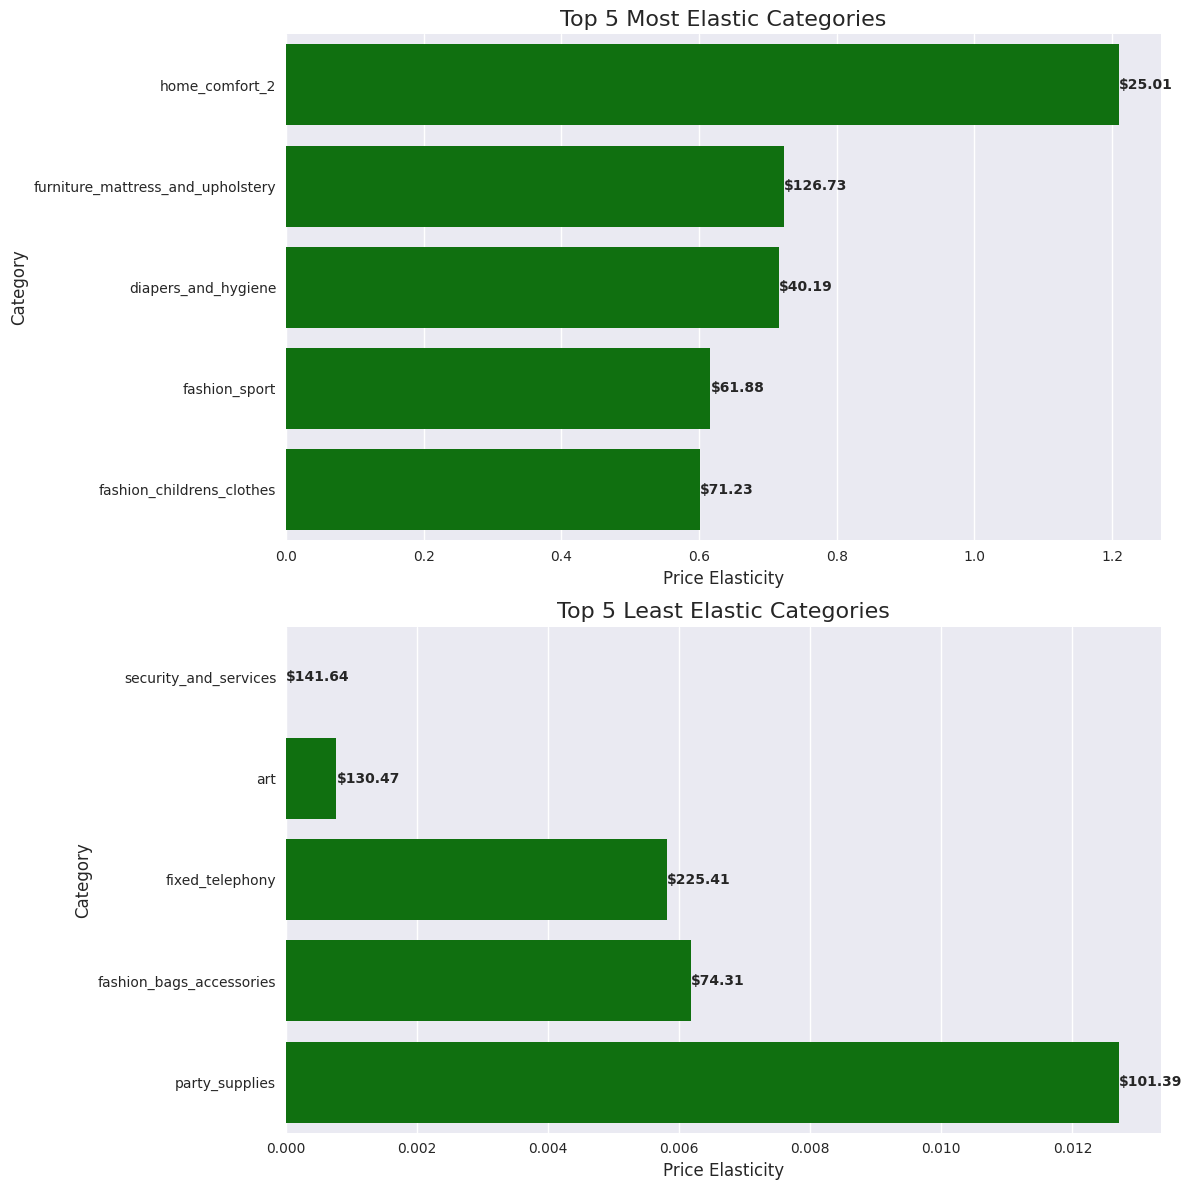

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Top 5 Most Elastic Categories
most_elastic = category_sales.reindex(category_sales['elasticity'].abs().sort_values(ascending=False).index).head()
colors_most = ['red' if x < 0 else 'green' for x in most_elastic['elasticity']]

sns.barplot(x='elasticity', y='category', data=most_elastic, ax=ax1, palette=colors_most)
ax1.set_title('Top 5 Most Elastic Categories', fontsize=16)
ax1.set_xlabel('Price Elasticity', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)

# Add average price annotations
for i, v in enumerate(most_elastic['elasticity']):
    ax1.text(v, i, f"${most_elastic['avg_price'].iloc[i]:.2f}", va='center', fontweight='bold')

# Top 5 Least Elastic Categories
least_elastic = category_sales.reindex(category_sales['elasticity'].abs().sort_values().index).head()
colors_least = ['red' if x < 0 else 'green' for x in least_elastic['elasticity']]

sns.barplot(x='elasticity', y='category', data=least_elastic, ax=ax2, palette=colors_least)
ax2.set_title('Top 5 Least Elastic Categories', fontsize=16)
ax2.set_xlabel('Price Elasticity', fontsize=12)
ax2.set_ylabel('Category', fontsize=12)

# Add average price annotations
for i, v in enumerate(least_elastic['elasticity']):
    ax2.text(v, i, f"${least_elastic['avg_price'].iloc[i]:.2f}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

All Categories with Price Change Impact:
                                   category  elasticity    avg_price  \
46                           home_comfort_2    1.210319    25.009655   
41        furniture_mattress_and_upholstery    0.723589   126.733333   
23                      diapers_and_hygiene    0.716037    40.194615   
32                            fashion_sport    0.616494    61.882500   
29                fashion_childrens_clothes    0.601227    71.231250   
8                    books_general_interest   -0.324069    83.255399   
50           industry_commerce_and_business    0.312706   155.435397   
24                                   drinks    0.291313    59.178628   
70                            watches_gifts    0.288399   201.005556   
13                               cine_photo    0.286059    96.298056   
26                              electronics    0.237769    50.056300   
51  kitchen_dining_laundry_garden_furniture    0.224434    84.770929   
33                  fas

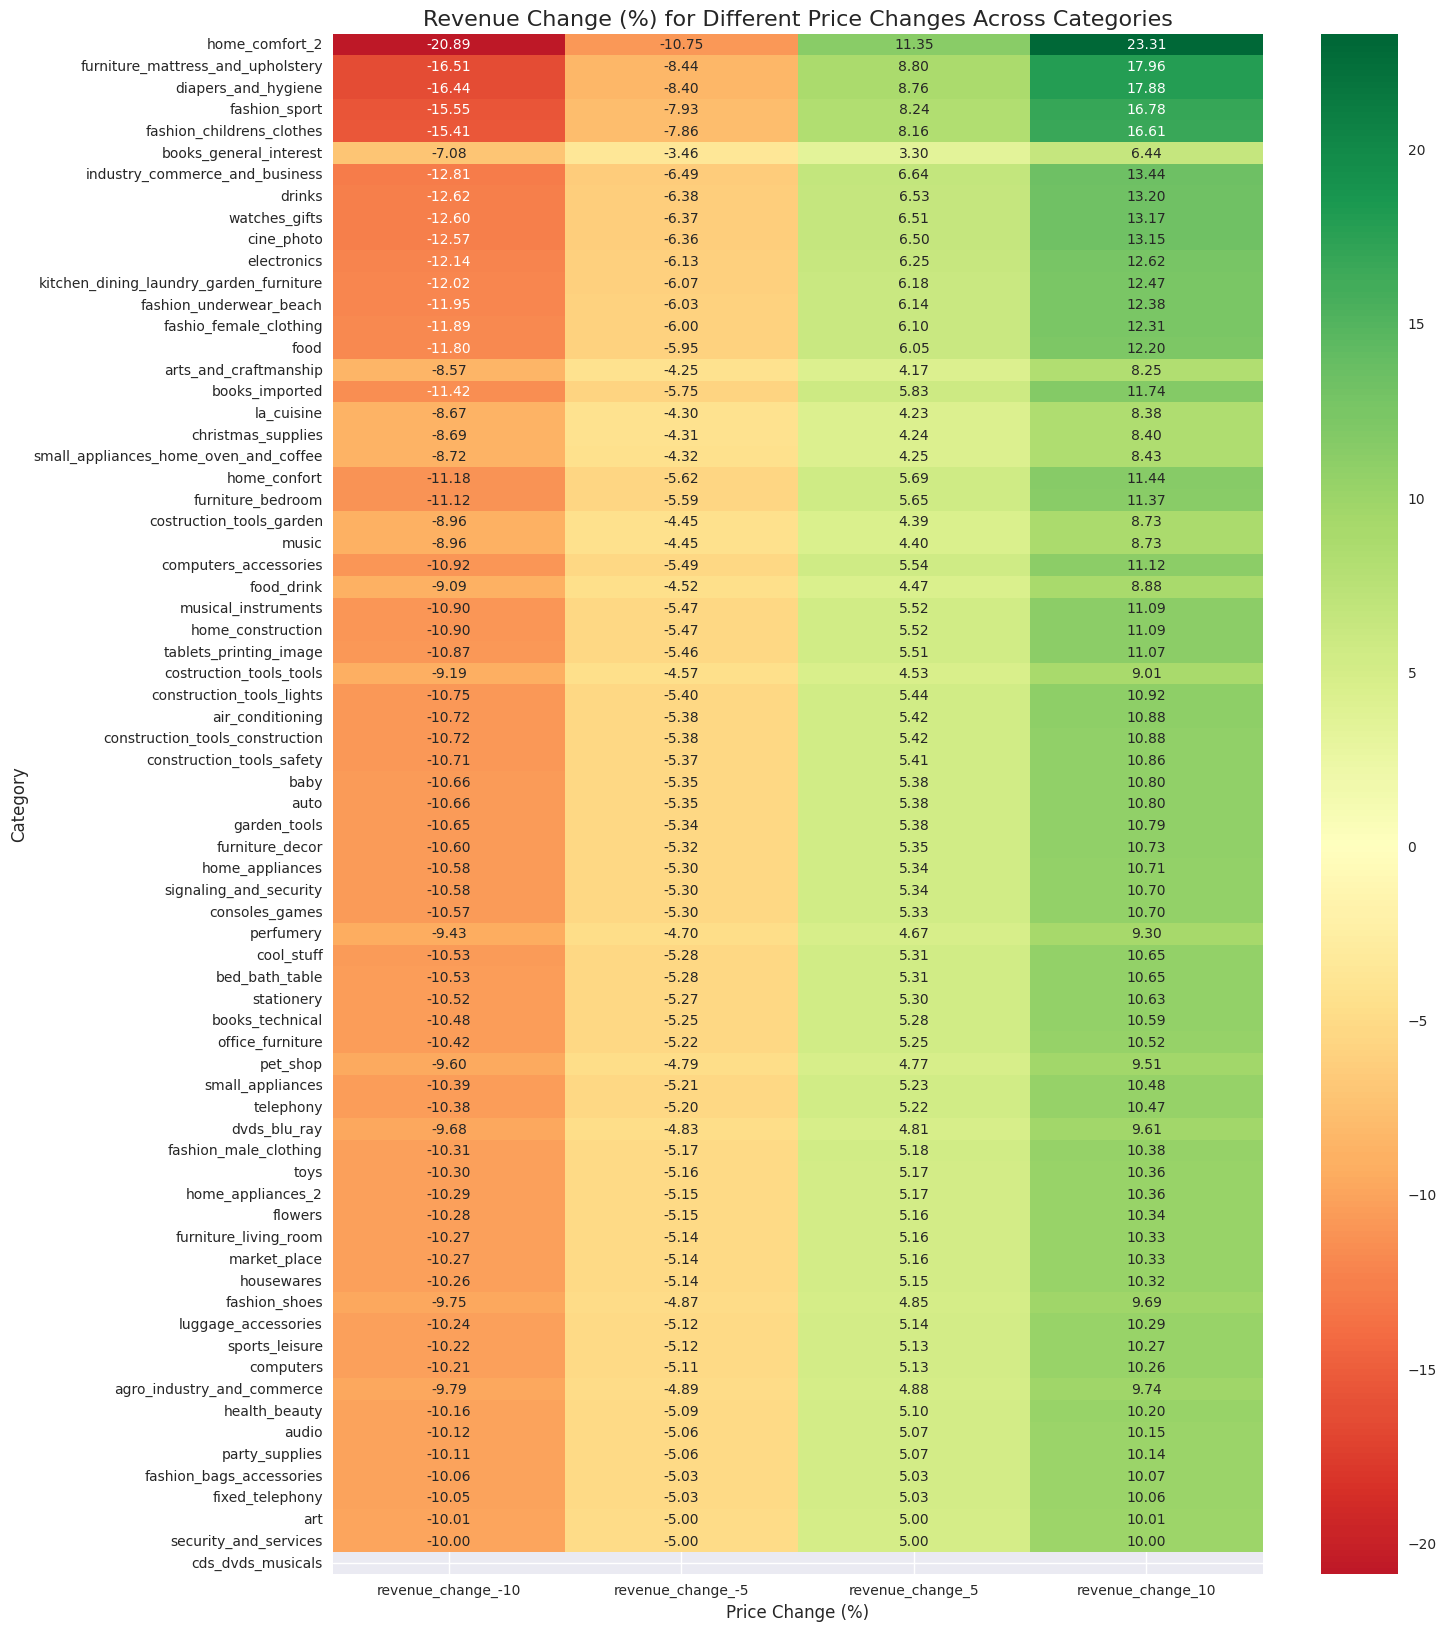


Total number of categories: 71
Number of categories with positive elasticity: 55
Number of categories with negative elasticity: 14
Average elasticity: 0.0989
Median elasticity: 0.0555

Correlation between elasticity and average price: -0.1514


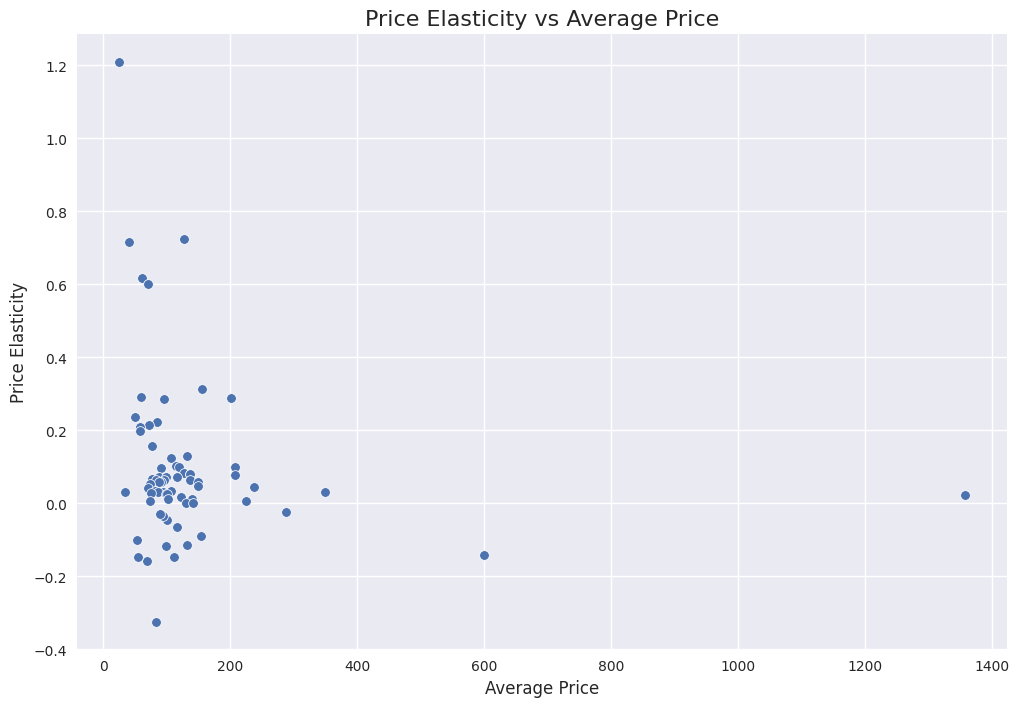

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi untuk menghitung perubahan permintaan
def calculate_demand_change(elasticity, price_change_percent):
    return elasticity * price_change_percent / 100

# Fungsi untuk menghitung perubahan pendapatan
def calculate_revenue_change(elasticity, price_change_percent):
    demand_change = calculate_demand_change(elasticity, price_change_percent)
    return (1 + price_change_percent/100) * (1 + demand_change) - 1

# Fungsi untuk menghitung dampak
def calculate_impact(row, price_change):
    elasticity = row['elasticity']
    avg_price = row['avg_price']
    new_price = avg_price * (1 + price_change/100)
    demand_change = calculate_demand_change(elasticity, price_change)
    revenue_change = calculate_revenue_change(elasticity, price_change)
    return pd.Series({
        f'new_price_{price_change}': new_price,
        f'demand_change_{price_change}': demand_change * 100,
        f'revenue_change_{price_change}': revenue_change * 100
    })

# Hitung dampak untuk setiap kategori
price_changes = [-10, -5, 5, 10]
for change in price_changes:
    category_sales = pd.concat([category_sales, category_sales.apply(calculate_impact, args=(change,), axis=1)], axis=1)

# Urutkan kategori berdasarkan nilai absolut elastisitas
sorted_categories = category_sales.reindex(category_sales['elasticity'].abs().sort_values(ascending=False).index)

# Tampilkan hasil
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("All Categories with Price Change Impact:")
print(sorted_categories[['category', 'elasticity', 'avg_price'] + 
                        [f'{col}_{change}' for change in price_changes for col in ['new_price', 'demand_change', 'revenue_change']]])

# Visualisasi: Heatmap untuk perubahan pendapatan
plt.figure(figsize=(15, 20))
heatmap_data = sorted_categories[[f'revenue_change_{change}' for change in price_changes]]
heatmap_data.index = sorted_categories['category']
sns.heatmap(heatmap_data, cmap='RdYlGn', center=0, annot=True, fmt='.2f')
plt.title('Revenue Change (%) for Different Price Changes Across Categories', fontsize=16)
plt.xlabel('Price Change (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

# Analisis tambahan
print(f"\nTotal number of categories: {len(sorted_categories)}")
print(f"Number of categories with positive elasticity: {sum(sorted_categories['elasticity'] > 0)}")
print(f"Number of categories with negative elasticity: {sum(sorted_categories['elasticity'] < 0)}")
print(f"Average elasticity: {sorted_categories['elasticity'].mean():.4f}")
print(f"Median elasticity: {sorted_categories['elasticity'].median():.4f}")

# Korelasi antara elastisitas dan harga rata-rata
correlation = sorted_categories['elasticity'].corr(sorted_categories['avg_price'])
print(f"\nCorrelation between elasticity and average price: {correlation:.4f}")

# Scatter plot elastisitas vs harga rata-rata
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_price', y='elasticity', data=sorted_categories)
plt.title('Price Elasticity vs Average Price', fontsize=16)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Price Elasticity', fontsize=12)
plt.show()

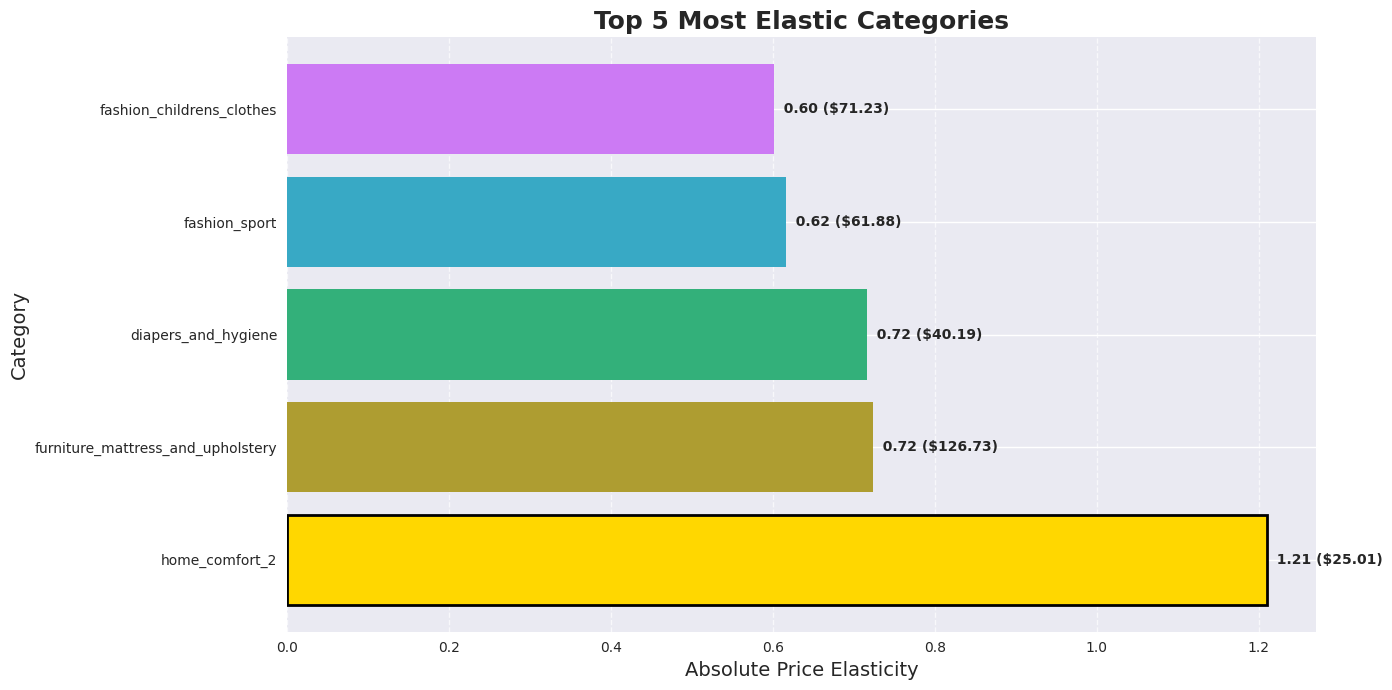

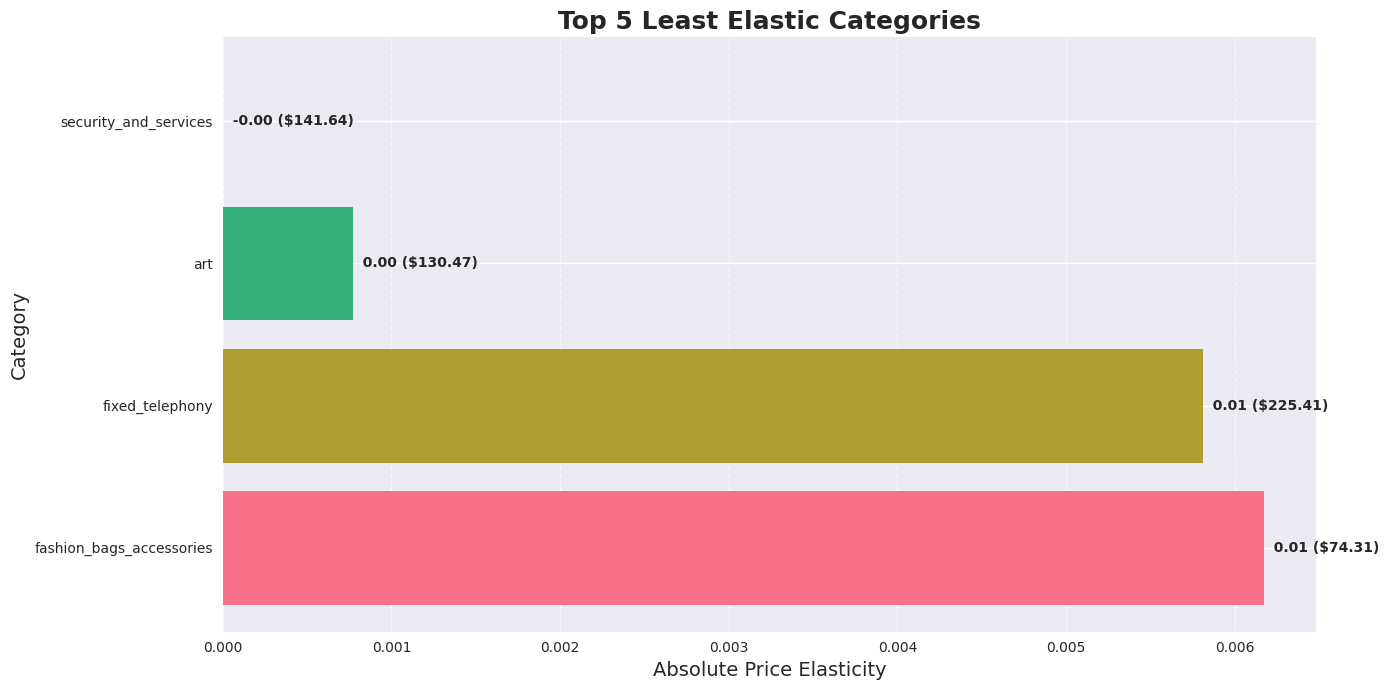

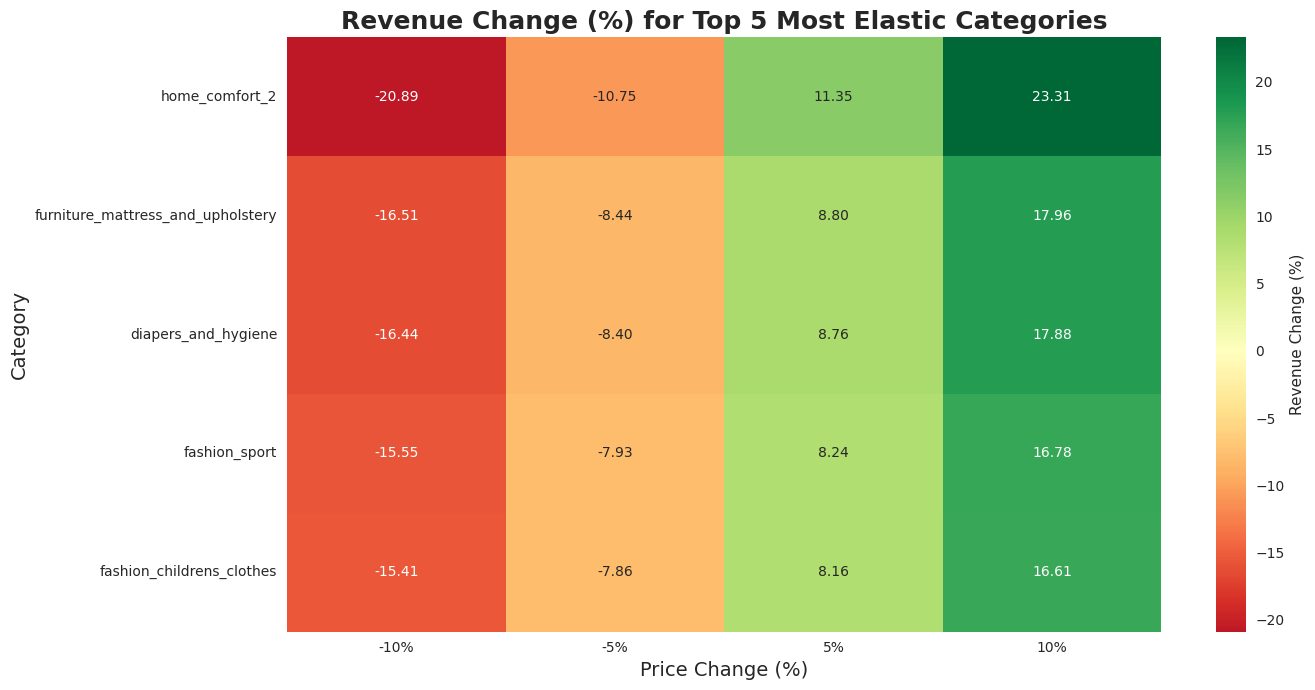

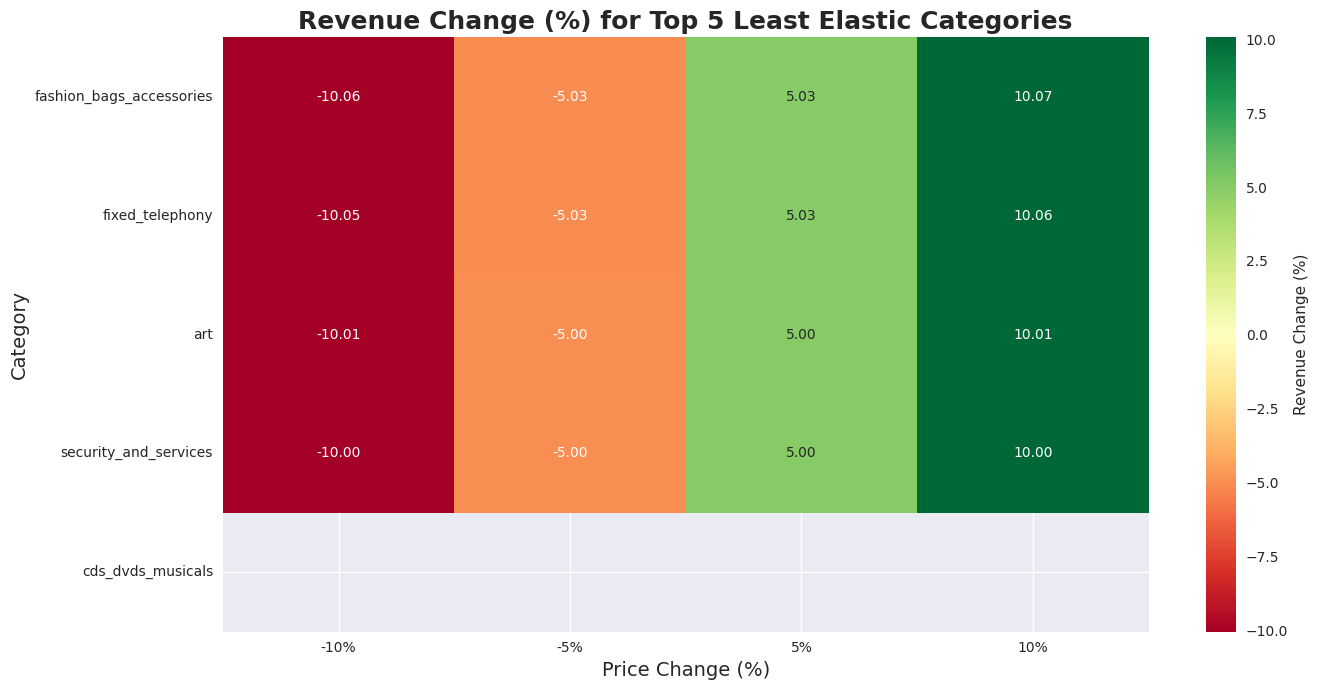

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ekstrak Top 5 Most Elastic dan Least Elastic categories
top_5_most_elastic = sorted_categories.head()
top_5_least_elastic = sorted_categories.tail()

# Fungsi untuk membuat bar plot dengan highlight
def create_enhanced_elasticity_plot(data, title, highlight_top=True):
    plt.figure(figsize=(14, 7))
    
    # Gunakan palet warna yang lebih beragam
    colors = sns.color_palette("husl", 5)
    
    # Buat bar plot
    bars = plt.barh(data['category'], data['elasticity'].abs(), color=colors)
    
    # Highlight bar teratas
    if highlight_top:
        bars[0].set_color('gold')
        bars[0].set_edgecolor('black')
        bars[0].set_linewidth(2)
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Absolute Price Elasticity', fontsize=14)
    plt.ylabel('Category', fontsize=14)
    
    # Tambahkan anotasi elastisitas dan harga rata-rata
    for i, (v, price) in enumerate(zip(data['elasticity'], data['avg_price'])):
        plt.text(abs(v), i, f"  {v:.2f} (${price:.2f})", va='center', fontweight='bold')
    
    # Tambahkan grid untuk memudahkan pembacaan
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Buat plot yang ditingkatkan untuk Top 5 Most Elastic dan Least Elastic categories
create_enhanced_elasticity_plot(top_5_most_elastic, 'Top 5 Most Elastic Categories')
create_enhanced_elasticity_plot(top_5_least_elastic, 'Top 5 Least Elastic Categories', highlight_top=False)

# Fungsi untuk membuat heatmap yang ditingkatkan
def create_enhanced_heatmap(data, title):
    plt.figure(figsize=(14, 7))
    
    heatmap_data = data[[f'revenue_change_{change}' for change in price_changes]]
    heatmap_data.index = data['category']
    
    # Gunakan palet warna yang lebih kontras
    sns.heatmap(heatmap_data, cmap='RdYlGn', center=0, annot=True, fmt='.2f', 
                cbar_kws={'label': 'Revenue Change (%)'})
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Price Change (%)', fontsize=14)
    plt.ylabel('Category', fontsize=14)
    
    # Atur label sumbu x
    plt.xticks(np.arange(4) + 0.5, ['-10%', '-5%', '5%', '10%'], rotation=0)
    
    plt.tight_layout()
    plt.show()

# Buat heatmap yang ditingkatkan
create_enhanced_heatmap(top_5_most_elastic, 'Revenue Change (%) for Top 5 Most Elastic Categories')
create_enhanced_heatmap(top_5_least_elastic, 'Revenue Change (%) for Top 5 Least Elastic Categories')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


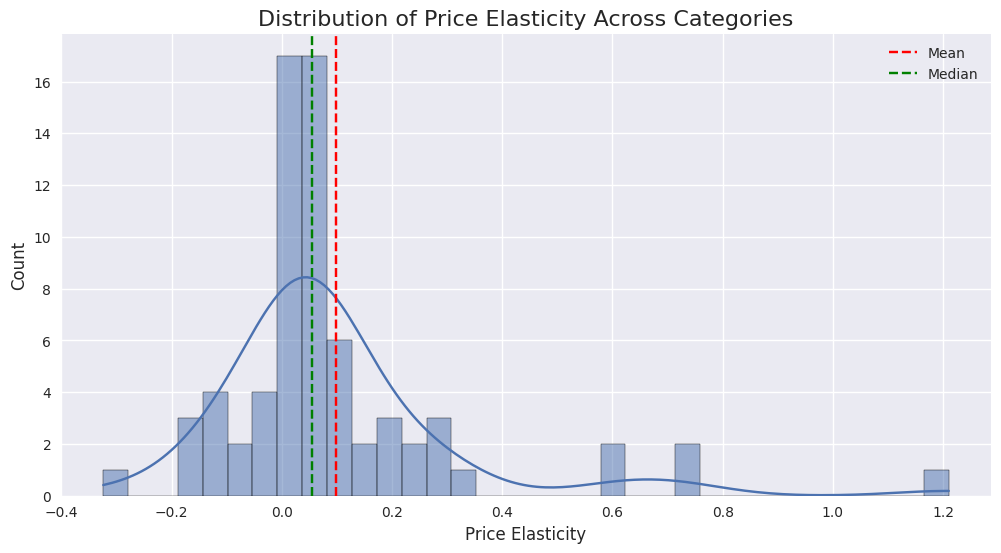

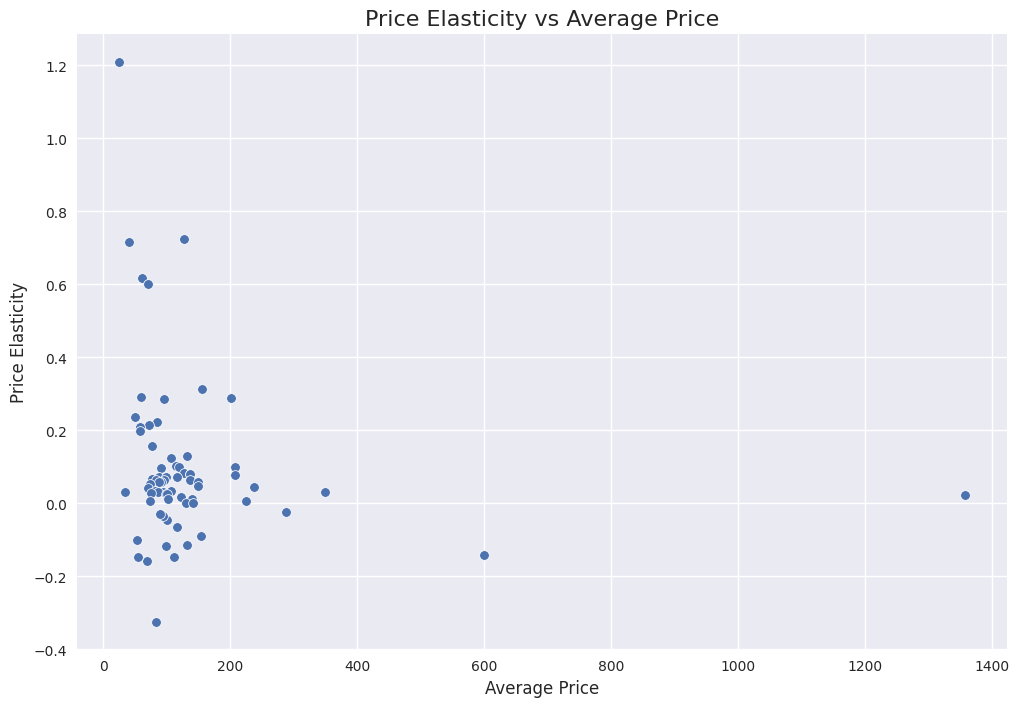

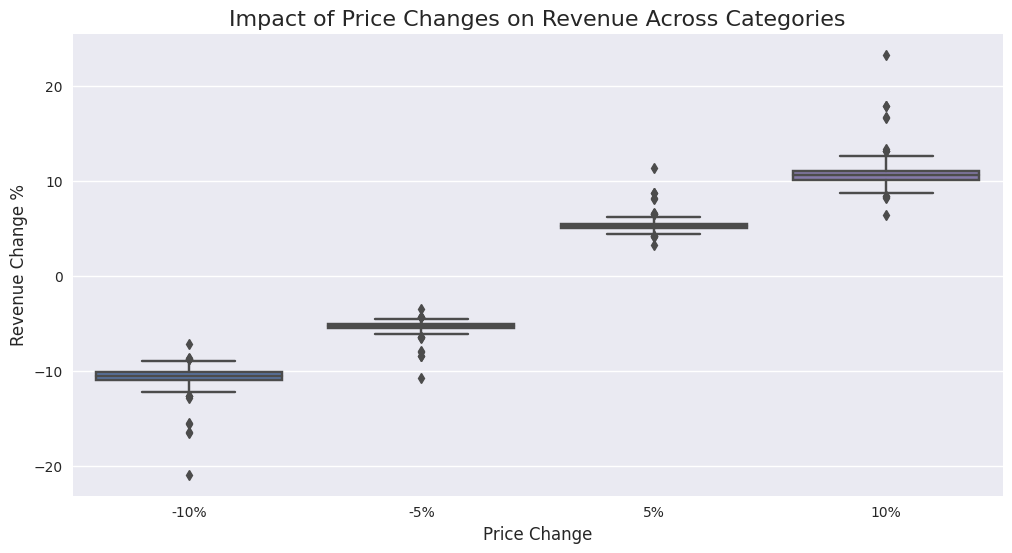

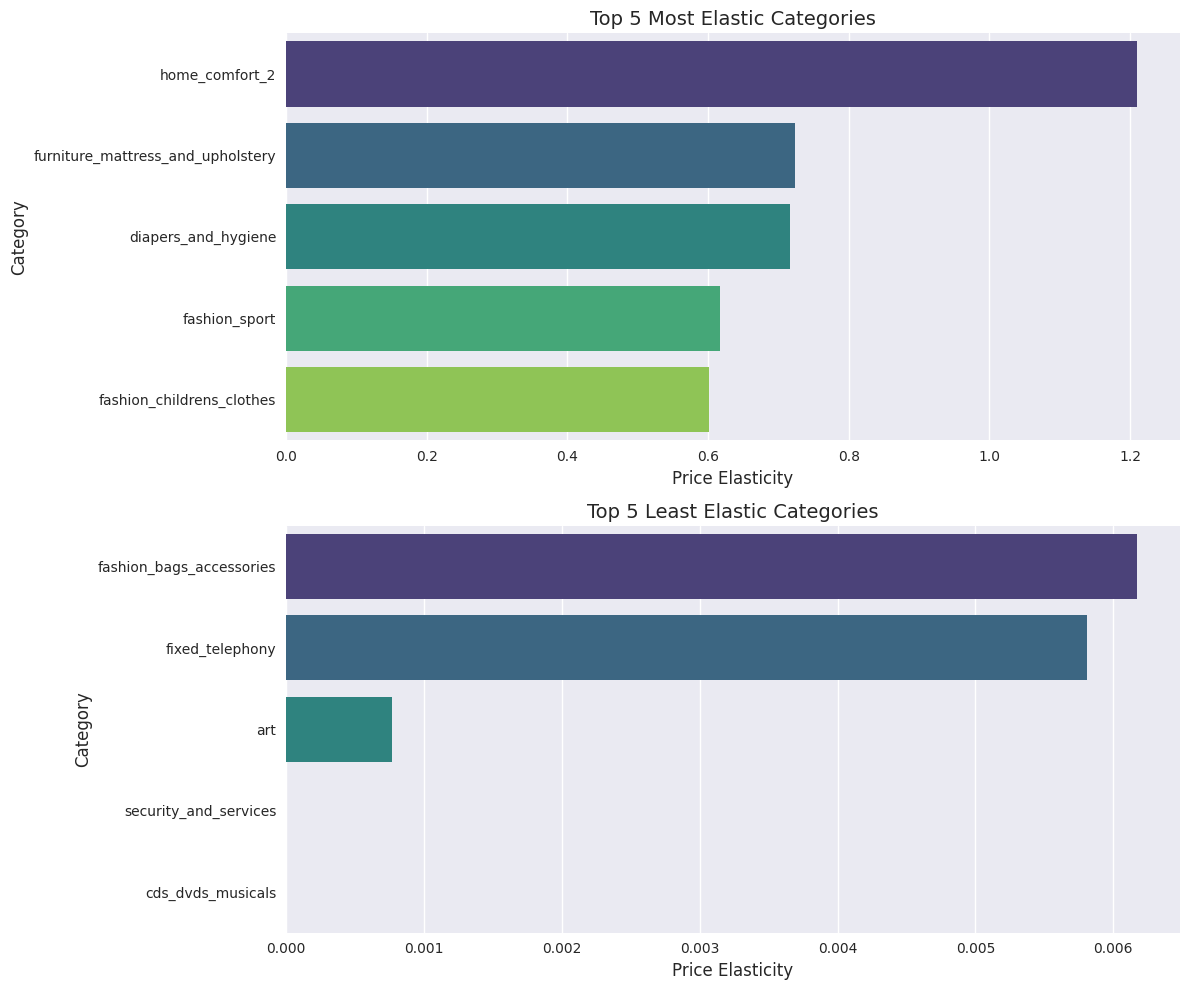

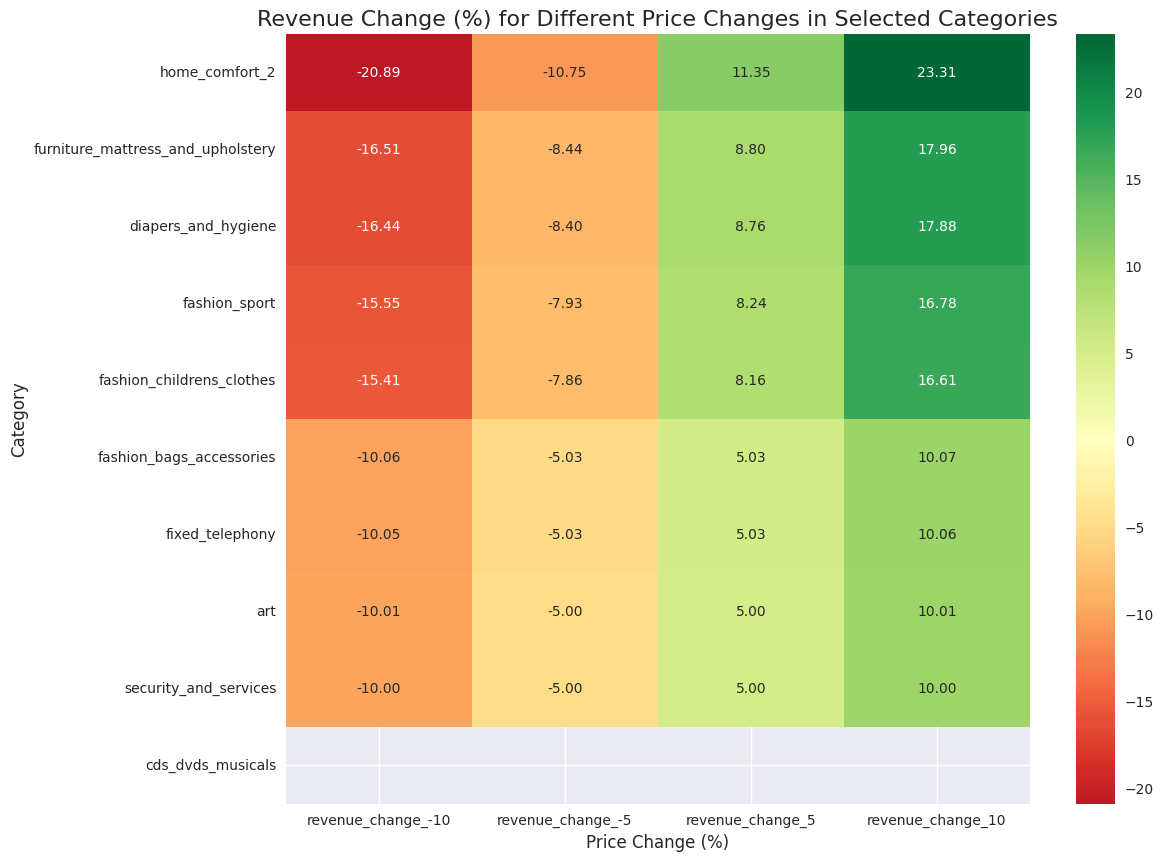

Total number of categories: 71
Number of categories with positive elasticity: 55
Number of categories with negative elasticity: 14
Average elasticity: 0.0989
Median elasticity: 0.0555
Correlation between elasticity and average price: -0.1514


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Distribusi Elastisitas
plt.figure(figsize=(12, 6))
sns.histplot(sorted_categories['elasticity'], kde=True)
plt.title('Distribution of Price Elasticity Across Categories', fontsize=16)
plt.xlabel('Price Elasticity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(sorted_categories['elasticity'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(sorted_categories['elasticity'].median(), color='g', linestyle='--', label='Median')
plt.legend()
plt.show()

# 2. Scatter plot: Elastisitas vs Harga Rata-rata
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_price', y='elasticity', data=sorted_categories)
plt.title('Price Elasticity vs Average Price', fontsize=16)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Price Elasticity', fontsize=12)
plt.show()

# 3. Box plot: Dampak Perubahan Harga terhadap Pendapatan
impact_data = sorted_categories[[f'revenue_change_{change}' for change in price_changes]]
impact_data = impact_data.melt(var_name='Price Change', value_name='Revenue Change %')
impact_data['Price Change'] = impact_data['Price Change'].map({
    'revenue_change_-10': '-10%',
    'revenue_change_-5': '-5%',
    'revenue_change_5': '5%',
    'revenue_change_10': '10%'
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Price Change', y='Revenue Change %', data=impact_data)
plt.title('Impact of Price Changes on Revenue Across Categories', fontsize=16)
plt.xlabel('Price Change', fontsize=12)
plt.ylabel('Revenue Change %', fontsize=12)
plt.show()

# 4. Top 5 Most and Least Elastic Categories
top_5_most = sorted_categories.head()
top_5_least = sorted_categories.tail()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.barplot(x='elasticity', y='category', data=top_5_most, ax=ax1, palette='viridis')
ax1.set_title('Top 5 Most Elastic Categories', fontsize=14)
ax1.set_xlabel('Price Elasticity', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)

sns.barplot(x='elasticity', y='category', data=top_5_least, ax=ax2, palette='viridis')
ax2.set_title('Top 5 Least Elastic Categories', fontsize=14)
ax2.set_xlabel('Price Elasticity', fontsize=12)
ax2.set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()

# 5. Heatmap: Dampak Perubahan Harga terhadap Pendapatan untuk Kategori Terpilih
selected_categories = pd.concat([top_5_most, top_5_least])
heatmap_data = selected_categories[[f'revenue_change_{change}' for change in price_changes]]
heatmap_data.index = selected_categories['category']

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='RdYlGn', center=0, annot=True, fmt='.2f')
plt.title('Revenue Change (%) for Different Price Changes in Selected Categories', fontsize=16)
plt.xlabel('Price Change (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

# Print summary statistics
print(f"Total number of categories: {len(sorted_categories)}")
print(f"Number of categories with positive elasticity: {sum(sorted_categories['elasticity'] > 0)}")
print(f"Number of categories with negative elasticity: {sum(sorted_categories['elasticity'] < 0)}")
print(f"Average elasticity: {sorted_categories['elasticity'].mean():.4f}")
print(f"Median elasticity: {sorted_categories['elasticity'].median():.4f}")
print(f"Correlation between elasticity and average price: {correlation:.4f}")

## VERSI DEMANDNYA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


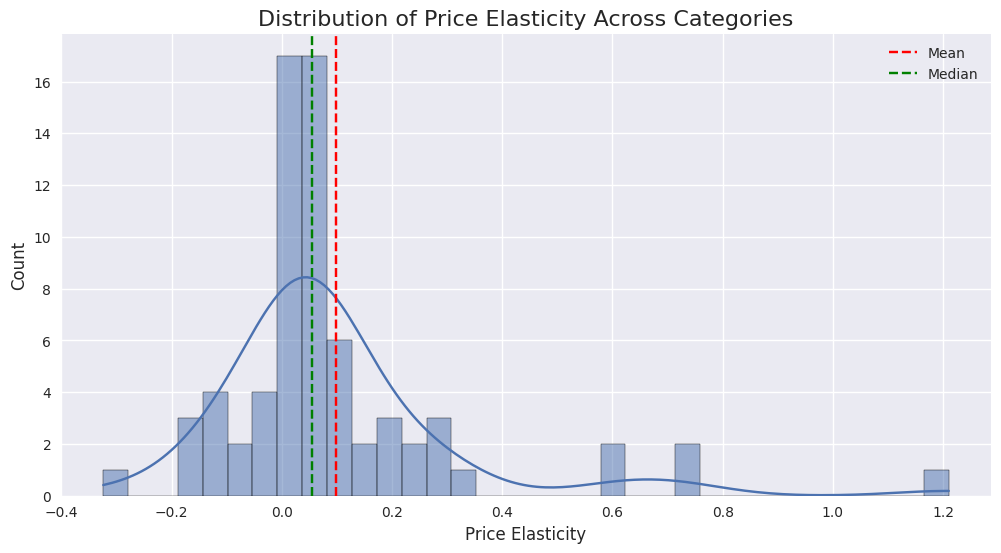

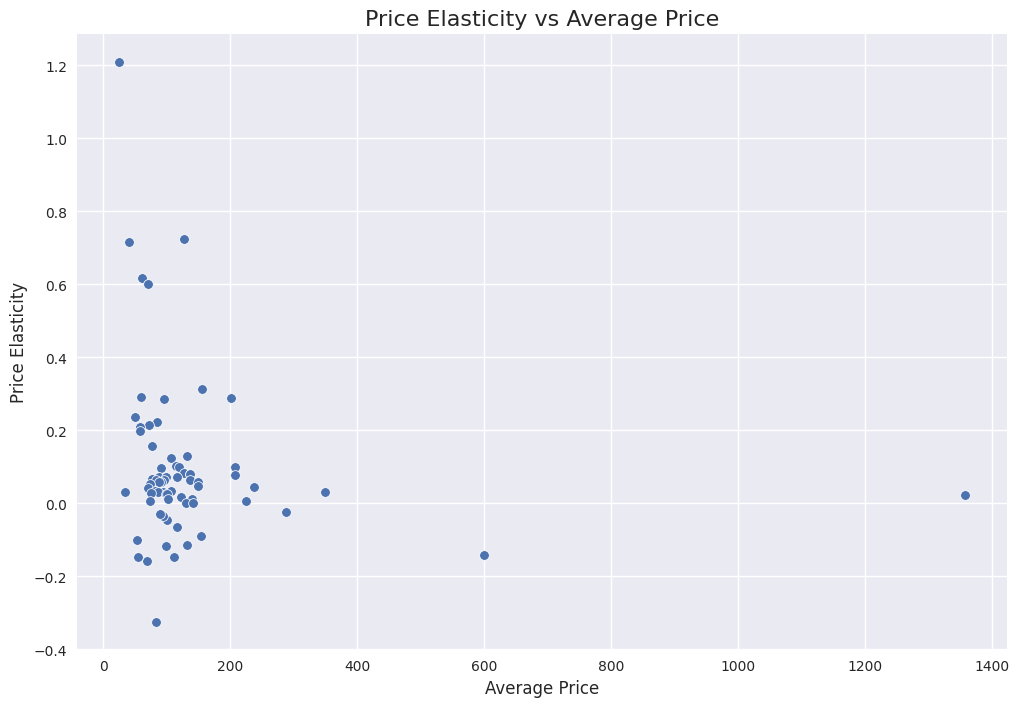

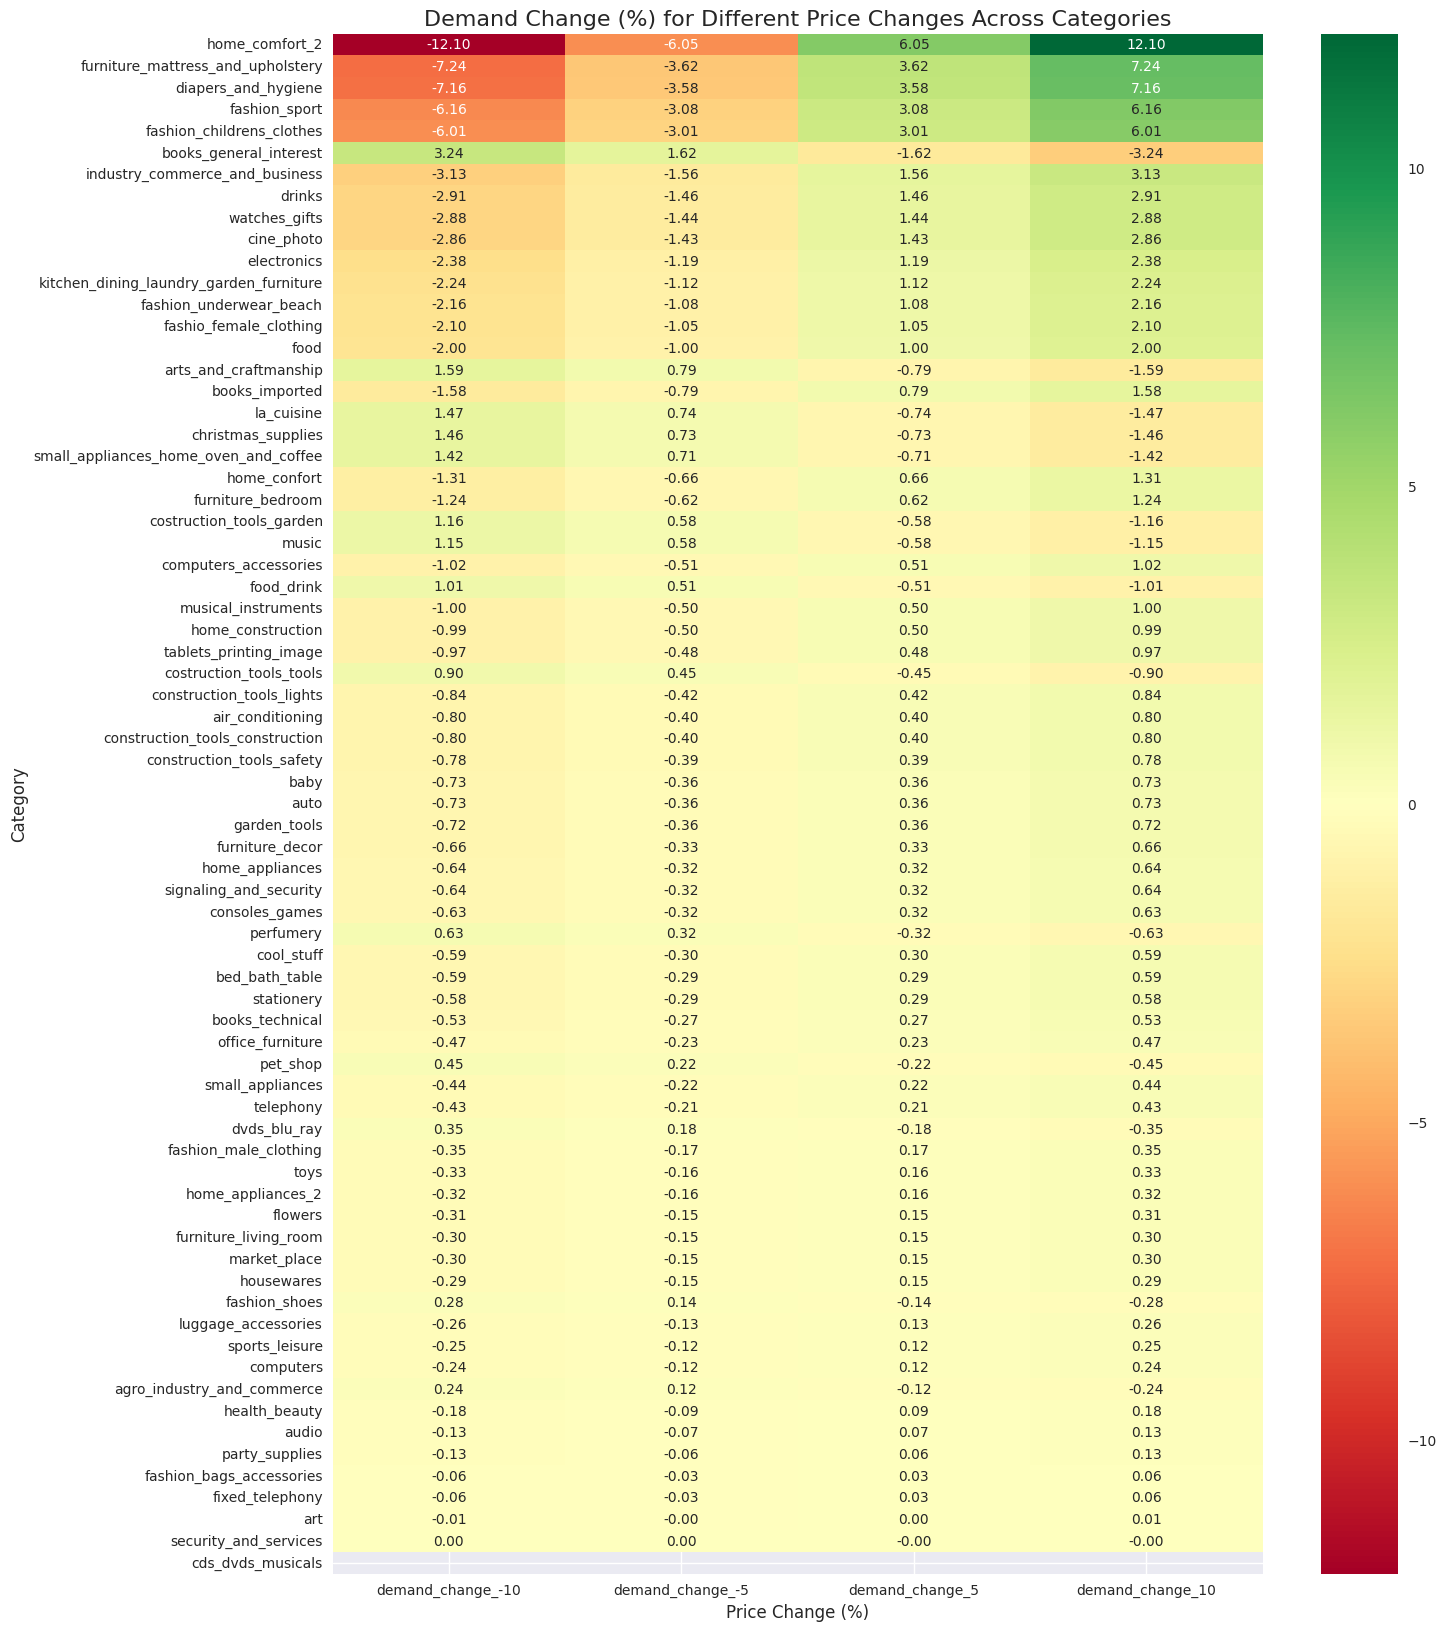

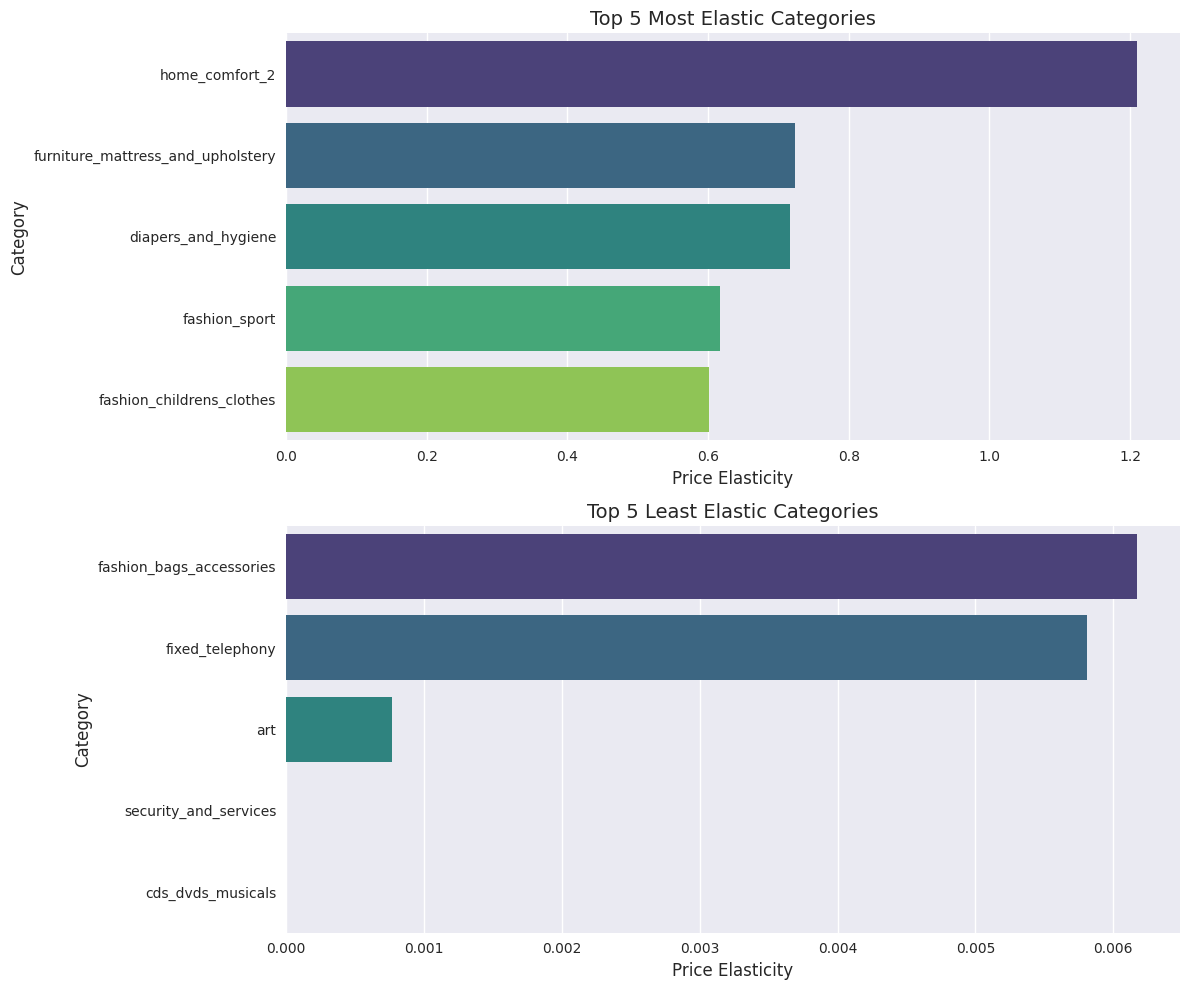

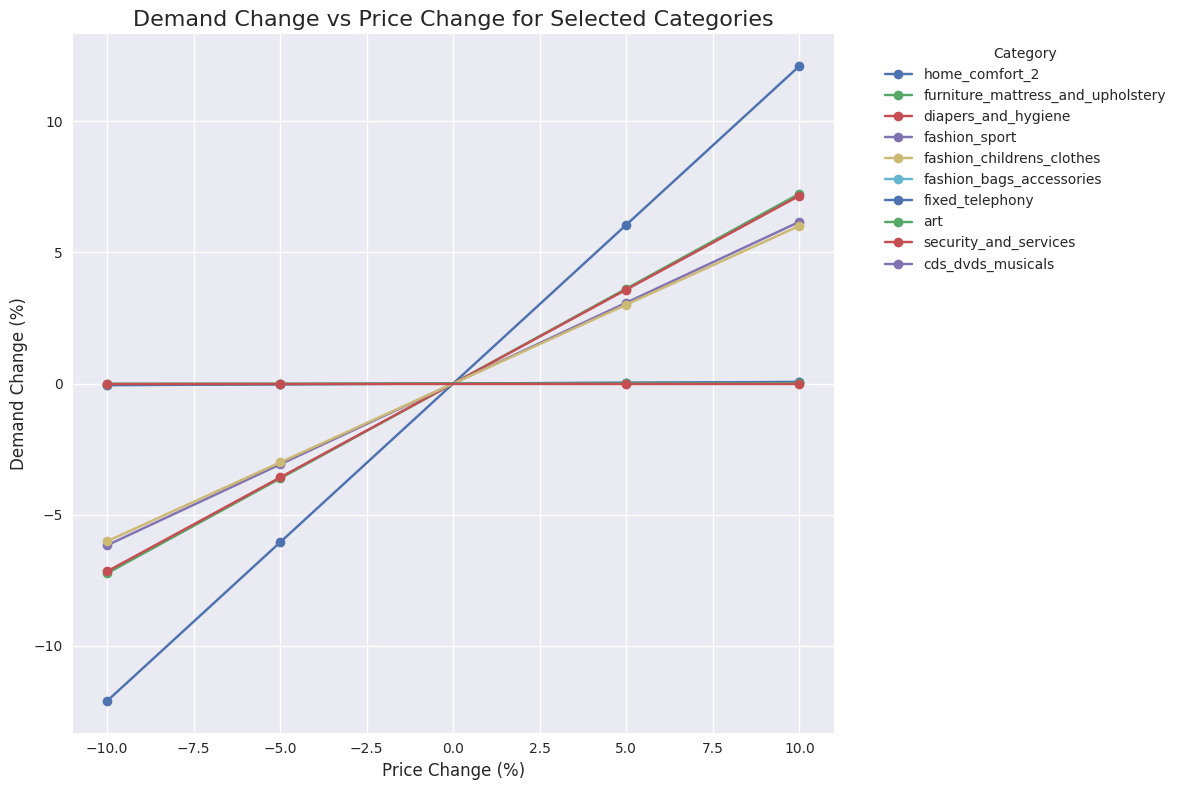


Total number of categories: 71
Number of categories with positive elasticity: 55
Number of categories with negative elasticity: 14
Average elasticity: 0.0989
Median elasticity: 0.0555

Correlation between elasticity and average price: -0.1514


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Distribusi Elastisitas
plt.figure(figsize=(12, 6))
sns.histplot(sorted_categories['elasticity'], kde=True)
plt.title('Distribution of Price Elasticity Across Categories', fontsize=16)
plt.xlabel('Price Elasticity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(sorted_categories['elasticity'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(sorted_categories['elasticity'].median(), color='g', linestyle='--', label='Median')
plt.legend()
plt.show()

# 2. Scatter plot: Elastisitas vs Harga Rata-rata
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_price', y='elasticity', data=sorted_categories)
plt.title('Price Elasticity vs Average Price', fontsize=16)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Price Elasticity', fontsize=12)
plt.show()

# 3. Heatmap untuk perubahan permintaan
plt.figure(figsize=(15, 20))
demand_heatmap_data = sorted_categories[[f'demand_change_{change}' for change in price_changes]]
demand_heatmap_data.index = sorted_categories['category']
sns.heatmap(demand_heatmap_data, cmap='RdYlGn', center=0, annot=True, fmt='.2f')
plt.title('Demand Change (%) for Different Price Changes Across Categories', fontsize=16)
plt.xlabel('Price Change (%)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

# 4. Top 5 Most and Least Elastic Categories
top_5_most = sorted_categories.head()
top_5_least = sorted_categories.tail()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.barplot(x='elasticity', y='category', data=top_5_most, ax=ax1, palette='viridis')
ax1.set_title('Top 5 Most Elastic Categories', fontsize=14)
ax1.set_xlabel('Price Elasticity', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)

sns.barplot(x='elasticity', y='category', data=top_5_least, ax=ax2, palette='viridis')
ax2.set_title('Top 5 Least Elastic Categories', fontsize=14)
ax2.set_xlabel('Price Elasticity', fontsize=12)
ax2.set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()

# 5. Line plot: Perubahan Permintaan vs Perubahan Harga untuk Kategori Terpilih
selected_categories = pd.concat([top_5_most, top_5_least])
plt.figure(figsize=(12, 8))
for category in selected_categories['category']:
    category_data = selected_categories[selected_categories['category'] == category]
    demand_changes = [category_data[f'demand_change_{change}'].values[0] for change in price_changes]
    plt.plot(price_changes, demand_changes, marker='o', label=category)

plt.title('Demand Change vs Price Change for Selected Categories', fontsize=16)
plt.xlabel('Price Change (%)', fontsize=12)
plt.ylabel('Demand Change (%)', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal number of categories: {len(sorted_categories)}")
print(f"Number of categories with positive elasticity: {sum(sorted_categories['elasticity'] > 0)}")
print(f"Number of categories with negative elasticity: {sum(sorted_categories['elasticity'] < 0)}")
print(f"Average elasticity: {sorted_categories['elasticity'].mean():.4f}")
print(f"Median elasticity: {sorted_categories['elasticity'].median():.4f}")
print(f"\nCorrelation between elasticity and average price: {correlation:.4f}")

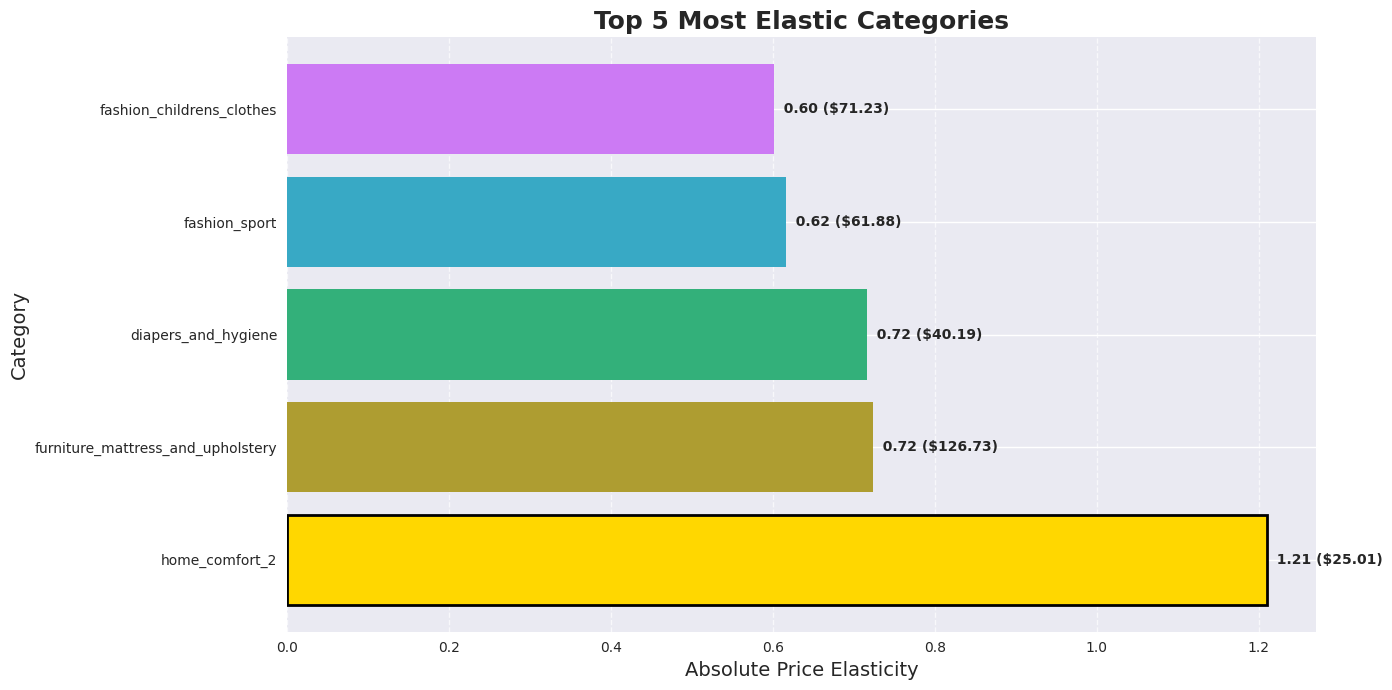

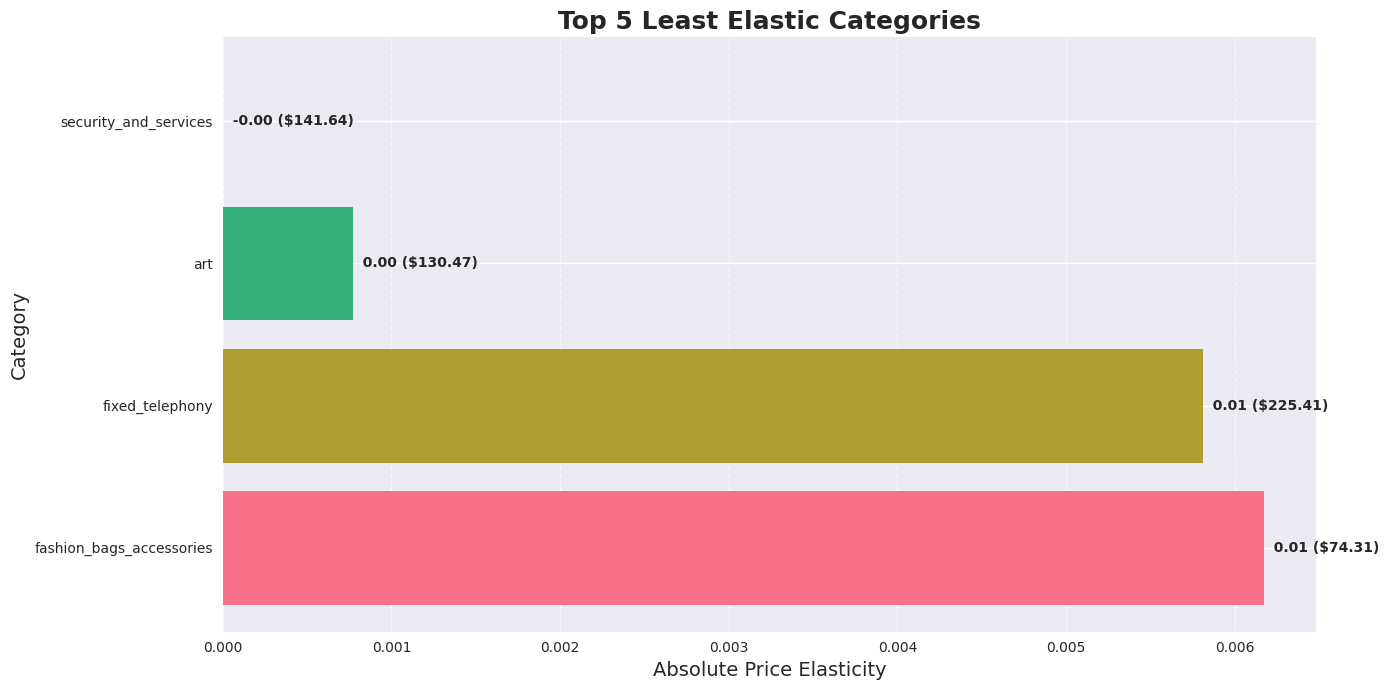

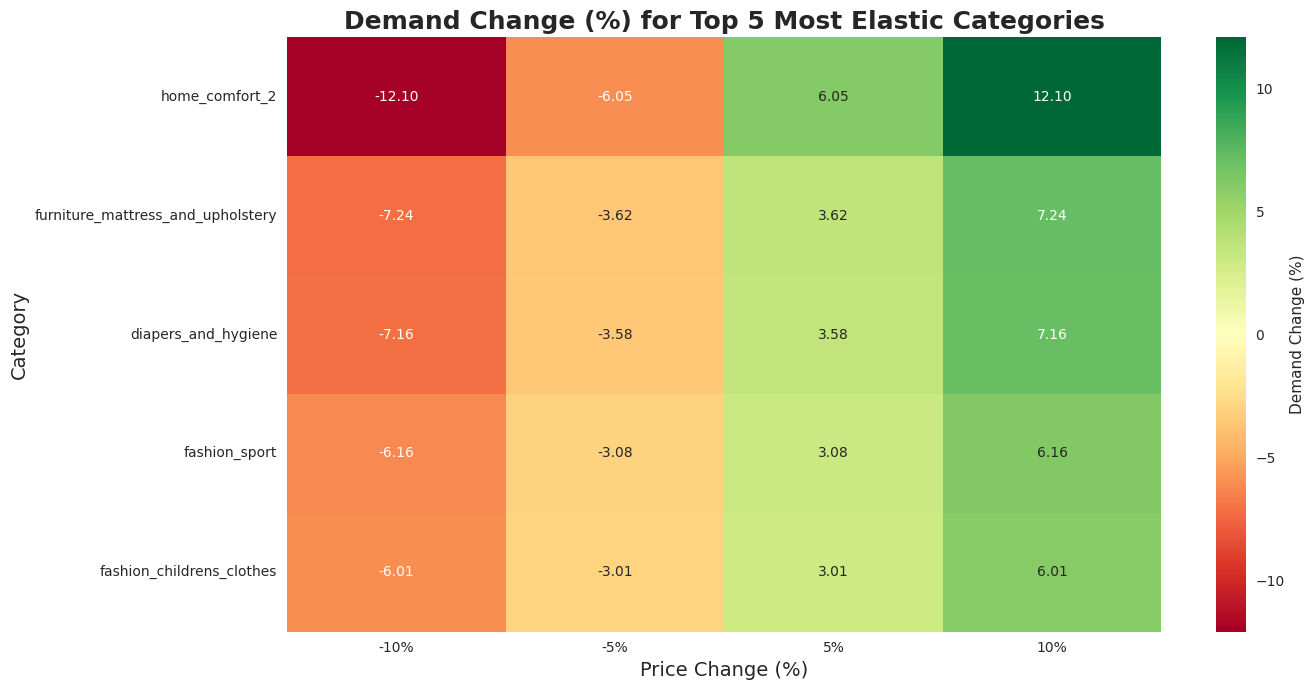

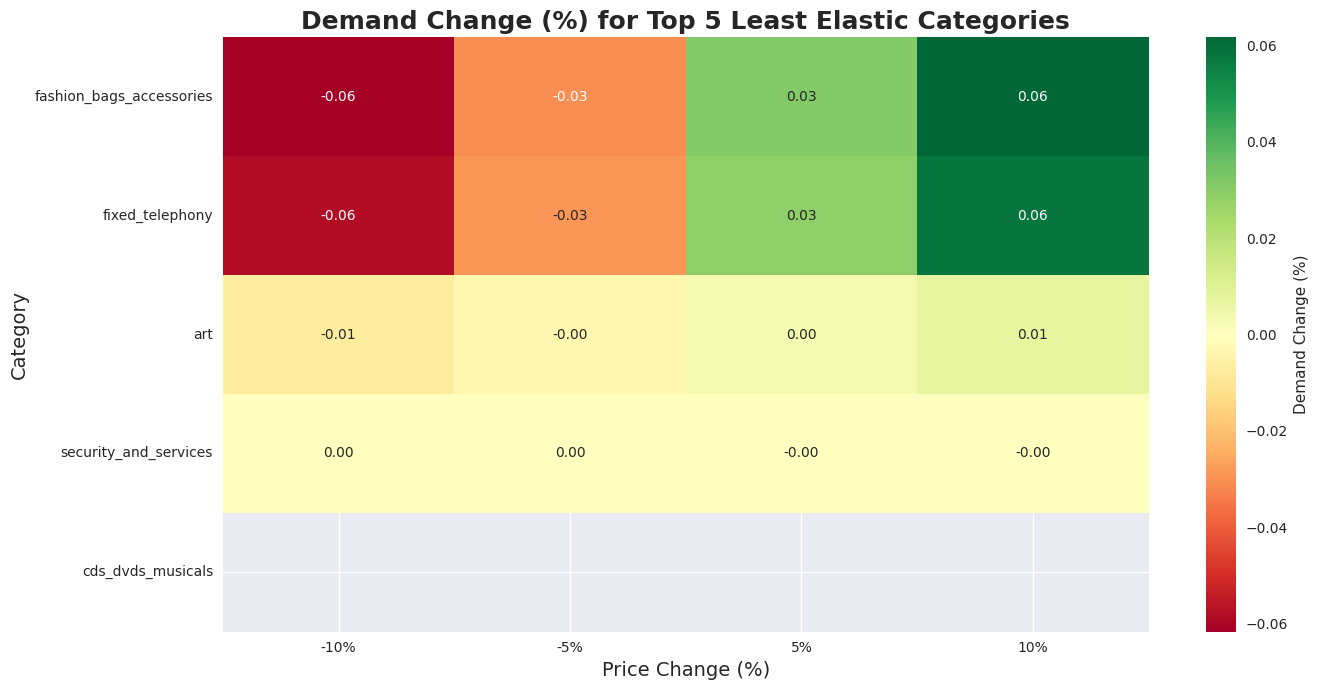

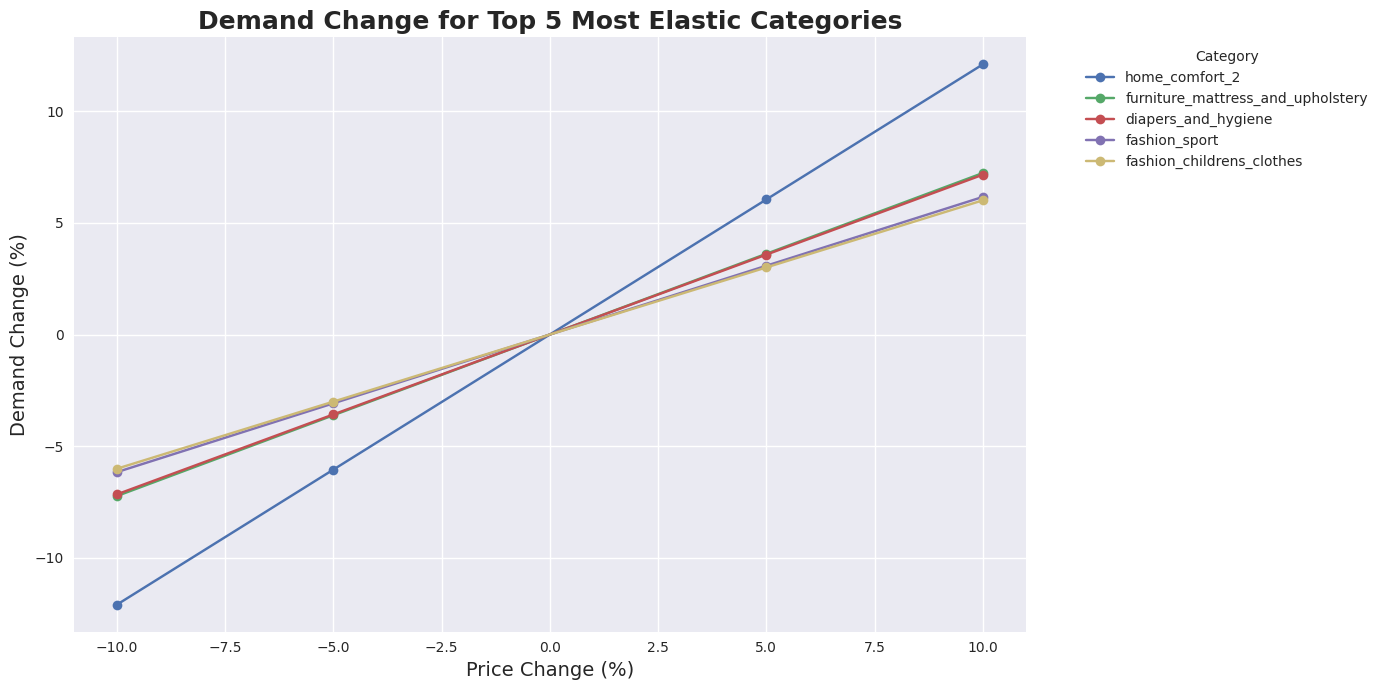

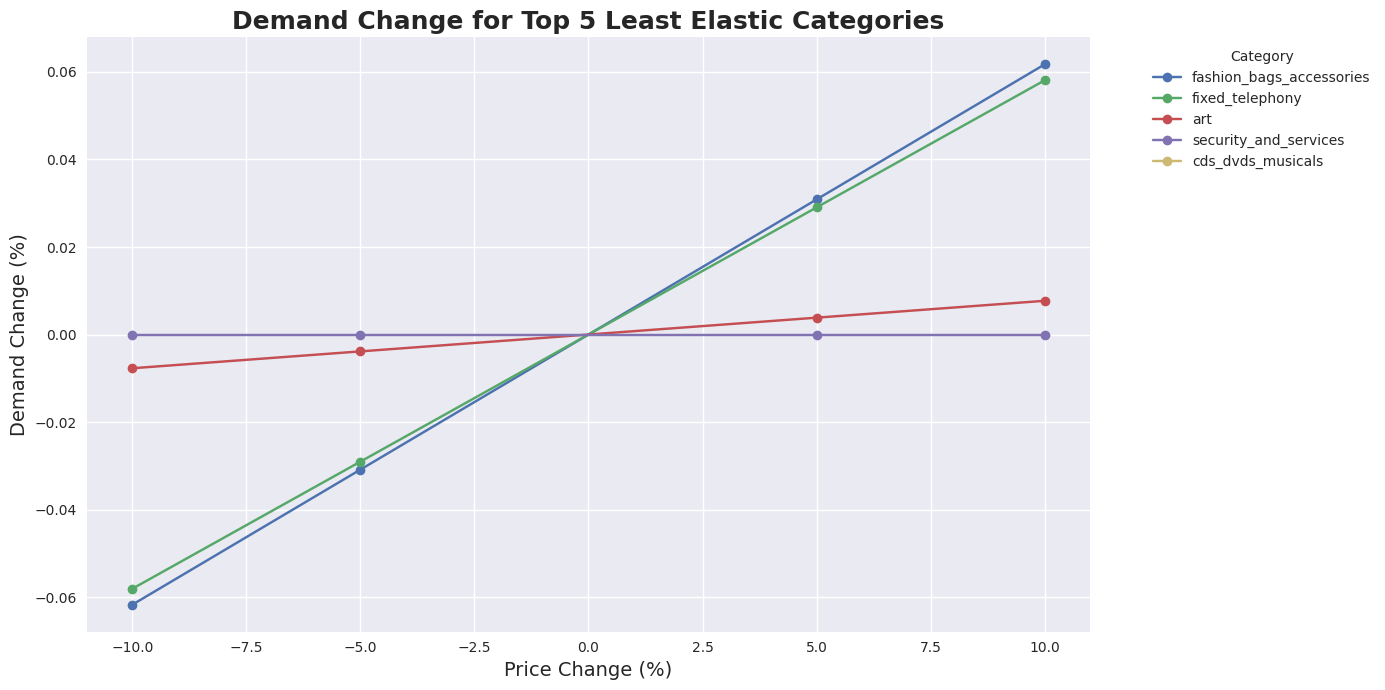

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ekstrak Top 5 Most Elastic dan Least Elastic categories
top_5_most_elastic = sorted_categories.head()
top_5_least_elastic = sorted_categories.tail()

# Fungsi untuk membuat bar plot dengan highlight
def create_enhanced_elasticity_plot(data, title, highlight_top=True):
    plt.figure(figsize=(14, 7))
    
    # Gunakan palet warna yang lebih beragam
    colors = sns.color_palette("husl", 5)
    
    # Buat bar plot
    bars = plt.barh(data['category'], data['elasticity'].abs(), color=colors)
    
    # Highlight bar teratas
    if highlight_top:
        bars[0].set_color('gold')
        bars[0].set_edgecolor('black')
        bars[0].set_linewidth(2)
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Absolute Price Elasticity', fontsize=14)
    plt.ylabel('Category', fontsize=14)
    
    # Tambahkan anotasi elastisitas dan harga rata-rata
    for i, (v, price) in enumerate(zip(data['elasticity'], data['avg_price'])):
        plt.text(abs(v), i, f"  {v:.2f} (${price:.2f})", va='center', fontweight='bold')
    
    # Tambahkan grid untuk memudahkan pembacaan
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Buat plot yang ditingkatkan untuk Top 5 Most Elastic dan Least Elastic categories
create_enhanced_elasticity_plot(top_5_most_elastic, 'Top 5 Most Elastic Categories')
create_enhanced_elasticity_plot(top_5_least_elastic, 'Top 5 Least Elastic Categories', highlight_top=False)

# Fungsi untuk membuat heatmap yang ditingkatkan untuk demand change
def create_enhanced_demand_heatmap(data, title):
    plt.figure(figsize=(14, 7))
    
    heatmap_data = data[[f'demand_change_{change}' for change in price_changes]]
    heatmap_data.index = data['category']
    
    # Gunakan palet warna yang lebih kontras
    sns.heatmap(heatmap_data, cmap='RdYlGn', center=0, annot=True, fmt='.2f', 
                cbar_kws={'label': 'Demand Change (%)'})
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Price Change (%)', fontsize=14)
    plt.ylabel('Category', fontsize=14)
    
    # Atur label sumbu x
    plt.xticks(np.arange(4) + 0.5, ['-10%', '-5%', '5%', '10%'], rotation=0)
    
    plt.tight_layout()
    plt.show()

# Buat heatmap yang ditingkatkan untuk demand change
create_enhanced_demand_heatmap(top_5_most_elastic, 'Demand Change (%) for Top 5 Most Elastic Categories')
create_enhanced_demand_heatmap(top_5_least_elastic, 'Demand Change (%) for Top 5 Least Elastic Categories')

# Fungsi untuk membuat line plot perubahan demand
def create_demand_change_line_plot(data, title):
    plt.figure(figsize=(14, 7))
    
    for _, row in data.iterrows():
        demand_changes = [row[f'demand_change_{change}'] for change in price_changes]
        plt.plot(price_changes, demand_changes, marker='o', label=row['category'])
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Price Change (%)', fontsize=14)
    plt.ylabel('Demand Change (%)', fontsize=14)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Buat line plot untuk perubahan demand
create_demand_change_line_plot(top_5_most_elastic, 'Demand Change for Top 5 Most Elastic Categories')
create_demand_change_line_plot(top_5_least_elastic, 'Demand Change for Top 5 Least Elastic Categories')